For this notebook you need to install:

- `tensorflow`
- `keras`
- `keras-vis`

The easiest way is to first install the `anaconda` distribution for `python` (preferably `Python 3`) and then use in a terminal

    conda install pip
 
`pip` is the python package installation tool. Then, you can simply use

    pip install tensorflow
    pip install keras
    pip install keras-vis

which should install everything easily.

The `numpy` library does some expensive operations outside Python using efficient code (Fortran, C/C++). However, switching back to python after each operation cause a big overhead because of unnecessary copies of the data. 

The library `tensorflow` does all the computations outside of Python: the python API is used to define a graph of operations, that will run entirely using C++ binaries. This architecture allows to get rid of the overhead. Besides, knowing the computational graph beforehand allows to parallelize and/or distribute the computation more easily. As a result, `tensoflow` can run the computations on multiple CPUs or GPUs, and on multiple servers.

However, for quick an easy model prototying, the library `keras` is simpler to use than `tensorflow`. 
Deep learning models can be constructed thanks to `keras` in few lines of python. So in this notebook, we won't see direct calls to `tensorflow`, but only to `keras`, even if the computations are done by `tensorflow`.

MNIST is a very old and standard benchmark dataset for image classification, so it's built-in (ready to be downloaded) in all machine learning libraries (including `keras` and `tensorflow`).

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle as pkl
import os

import tensorflow
import keras
from keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import activations

print("tensorflow version %s (should be at least 0.12.1)" % tensorflow.__version__)
print("keras version %s (should be at least 2.0.7)" % keras.__version__)

tensorflow version 2.0.0 (should be at least 0.12.1)
keras version 2.3.1 (should be at least 2.0.7)


Using TensorFlow backend.


In [0]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

### <font color=darkred> Handwritten digit recognition with MNIST</font>

For the first part of this tutorial, we will use the [MNIST](http://yann.lecun.com/exdb/mnist) dataset.
This dataset contains images representing handwritten digits. 
Each image is 28 x 28 pixels, and each pixel is represented by a number (gray level). 
These arrays can be flattened into vectors of 28 x 28 = 784 numbers.
You can then see each image as a point in a 784-dimensional vector space. 
You can find interesting visualisations of this vector space [http://colah.github.io/posts/2014-10-Visualizing-MNIST/](http://colah.github.io/posts/2014-10-Visualizing-MNIST/).

The labels in $\{0, 1, 2, \ldots, 9\}$ giving the digit on the image are be represented using one-hot encoding: labels in $\{0, 1, 2, \ldots, 9\}$ are replaced by labels in $\{ 0, 1\}^{10}$, namely $0$ is replaced by $(1, 0, \ldots 0)$, $1$ is replaced by $(0, 1, 0, \ldots 0)$, $2$ is replaced by $(0, 0, 1, 0, \ldots, 0)$, etc.

Also, MNIST data is grayscale pixels in $\{0, \ldots, 255\}$. The pixels should be normalized to belong to $[0, 1]$.
Indeed, working with big floats can lead to important numerical errors, in particular in deep learning models.

In [0]:
# Number of classes
num_classes = 10
# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
y_train shape: (60000,)
y_test shape: (10000,)
60000 train samples
10000 test samples


In the next cell we illustrate the first for elements of the training data: 
pixels grayscale of the digit and their corresponding label.

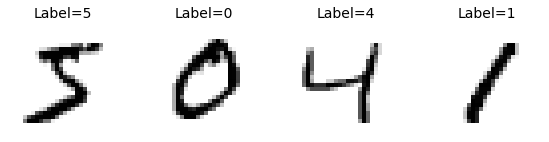

In [0]:
plt.figure(figsize=(8, 2))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(x_train[i].reshape(28, 28), 
               interpolation="none", cmap="gray_r")
    plt.title('Label=%d' % y_train[i], fontsize=14)
    plt.axis("off")
plt.tight_layout()

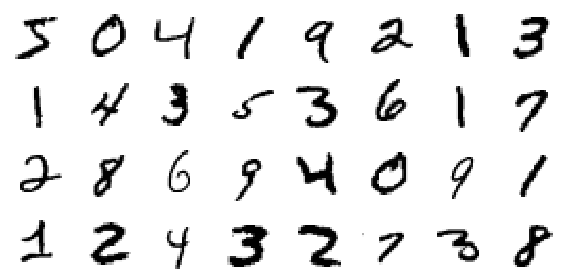

In [0]:
n_rows = 4
n_cols = 8
plt.figure(figsize=(8, 4))
for i in range(n_rows * n_cols):
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(x_train[i].reshape(28, 28),
               interpolation="none", cmap="gray_r")
    plt.axis("off")
plt.tight_layout()

The first character is a 5 digit, encoded in grayscale matrix.

We need to normalize the images and one-hot encode the labels.

In [0]:
x_train /= 255
x_test /= 255

In [0]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_train[:10]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

### <font color=darkred> Softmax regression for MNIST</font>

Logistic regression can be extended to classify data in more than two groups. Softmax regression provides a model for the probability that an input $x$ is associated with each group.  It is assumed that the probability to belong to the class $k\in\{1,\ldots,M\}$ can be expressed by 
\begin{equation*}
\mathbb{P}(Y = k| X) = \frac{\exp(\langle w_k,X \rangle + b_k)}{\sum_{\ell=1}^{M}\exp(\langle w_\ell,X \rangle + b_\ell)} = p_k(X)\,,
\end{equation*}
where $w_\ell \in \mathbb{R}^d$ and $b_\ell$  are model `weights` and `intercepts` for each class.


To estimate these unknown parameters, a maximum likelihood approach is used as in the logistic regression setting. In this case, the loss function is given by the negative log-likelihood (see also the section on gradient based method).

To train the model weights $W_{k, j}$ and $b_k$ for $k=1, \ldots, 10$ and $j=1, \ldots, 784$, we consider the loss function given by the negative log-likelihood.
For the considered model, the negative log-likelihood of a sample with input $x_i \in \mathbb R^{784}$ and label $y_i \in \{0, 1\}^{10}$, it is given by the cross-entropy between the scores $p_k(x_i)$ and the label $y_i$:
$$
- \sum_{k=1}^{10} y_{i, k} \log(p_k(x_i))
$$
For this first model, we will simply use stochastic gradient descent over small batches of data. It can be done easily with TensorFlow, as it will automatically and efficiently compute the gradient from your graph, then apply an optimization algorithm of your choice to perform the parameters update.

In [0]:
model = Sequential()
# First we need to flatten the data: replace 28 * 28 matrices by flat vectors
# This is always necessary before feeding data to a fully-connected layer (Dense object)
model.add(Flatten(input_shape=input_shape, name='flatten'))

model.add(Dense(num_classes, activation='softmax', name='dense_softmax'))

model.compile(
    # specify the loss as the cross-entropy
    loss=keras.losses.categorical_crossentropy,
    # choose the Adagrad solver, but you can choose others
    optimizer=keras.optimizers.Adagrad(),
    # to monitor the accuracy on a testing set along optimization
    metrics=['accuracy']
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_softmax (Dense)        (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [0]:
batch_size = 32
epochs = 50

# Run the train
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 5s 85us/step - loss: 0.4644 - accuracy: 0.8812 - val_loss: 0.3545 - val_accuracy: 0.9062
Epoch 2/50
60000/60000 [==============================] - 4s 70us/step - loss: 0.3520 - accuracy: 0.9039 - val_loss: 0.3261 - val_accuracy: 0.9121
Epoch 3/50
60000/60000 [==============================] - 4s 66us/step - loss: 0.3308 - accuracy: 0.9091 - val_loss: 0.3124 - val_accuracy: 0.9153
Epoch 4/50
60000/60000 [==============================] - 5s 77us/step - loss: 0.3193 - accuracy: 0.9116 - val_loss: 0.3053 - val_accuracy: 0.9167
Epoch 5/50
60000/60000 [==============================] - 4s 70us/step - loss: 0.3116 - accuracy: 0.9135 - val_loss: 0.2994 - val_accuracy: 0.9179
Epoch 6/50
60000/60000 [==============================] - 4s 71us/step - loss: 0.3061 - accuracy: 0.9151 - val_loss: 0.2962 - val_accuracy: 0.9172
Epoch 7/50
60000/60000 [==============================] - 4s 71us/st

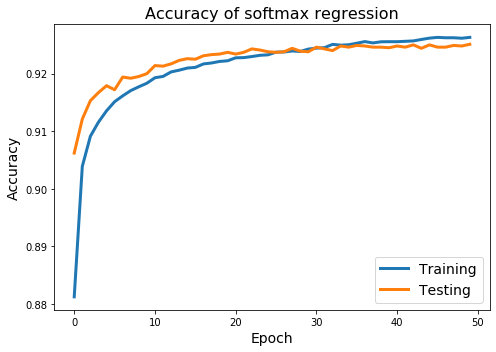

In [0]:
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['accuracy'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_accuracy'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Accuracy of softmax regression', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.tight_layout()

La régression softmax donne déjà de très bon résultats avec plus de 92% de réussite !

**Question**

Run a cross-validation to analyze the influence of the number of epochs and the batch-size.

Weight matrices plots show that the learned weights are consistant with the digits they should predict (see below).
You should be able to see rough shapes corresponding to the digits 0, 1, 2, 3, etc.

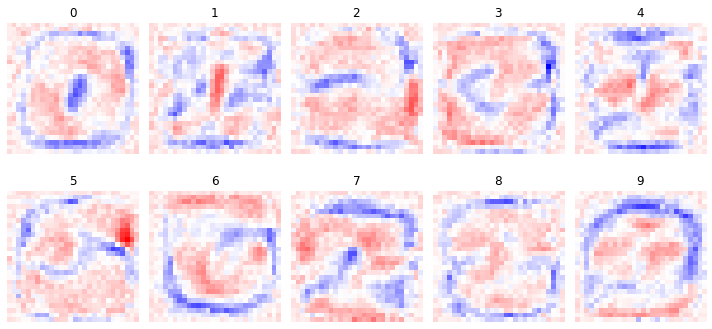

In [0]:
weights, biases = model.get_layer('dense_softmax').get_weights()
imgs = weights.reshape(28, 28, 10)

fig = plt.figure(figsize=(10, 5))
vmin, vmax = imgs.min(), imgs.max()
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    im = imgs[:, :, i]
    mappable = ax.imshow(im, interpolation="nearest", 
                         vmin=vmin, vmax=vmax, cmap='bwr')
    ax.axis('off')
    ax.set_title("%i" % i)
plt.tight_layout()

In [0]:
def model():
    layer_in = Flatten(input_shape=input_shape)
    model = Sequential()
    model.add(layer_in)
    
    layer_out = Dense(units = y_train.shape[1], activation="softmax")
    model.add(layer_out)
  
    model.compile(optimizer="adam", loss="mse",metrics=['accuracy'])
    return model


In [0]:
batch_size = [16,32,64,256,512]
epochs = 50
history=[]
score=[]
# Run the train
for i in range(len(batch_size)):
    
    history.append(model().fit(x_train, y_train,
                        batch_size=batch_size[i],
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test)))
    print(batch_size[i])
    
    

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 8s 138us/step - loss: 0.0176 - accuracy: 0.8916 - val_loss: 0.0122 - val_accuracy: 0.9235
Epoch 2/50
60000/60000 [==============================] - 8s 136us/step - loss: 0.0124 - accuracy: 0.9212 - val_loss: 0.0114 - val_accuracy: 0.9270
Epoch 3/50
60000/60000 [==============================] - 8s 136us/step - loss: 0.0115 - accuracy: 0.9271 - val_loss: 0.0108 - val_accuracy: 0.9309
Epoch 4/50
60000/60000 [==============================] - 8s 137us/step - loss: 0.0110 - accuracy: 0.9301 - val_loss: 0.0110 - val_accuracy: 0.9294
Epoch 5/50
60000/60000 [==============================] - 8s 137us/step - loss: 0.0107 - accuracy: 0.9327 - val_loss: 0.0108 - val_accuracy: 0.9313
Epoch 6/50
60000/60000 [==============================] - 8s 140us/step - loss: 0.0105 - accuracy: 0.9342 - val_loss: 0.0107 - val_accuracy: 0.9314
Epoch 7/50
60000/60000 [==============================] - 8s 1

60000/60000 [==============================] - 2s 41us/step - loss: 0.0103 - accuracy: 0.9355 - val_loss: 0.0107 - val_accuracy: 0.9300
Epoch 11/50
60000/60000 [==============================] - 2s 38us/step - loss: 0.0102 - accuracy: 0.9367 - val_loss: 0.0106 - val_accuracy: 0.9319
Epoch 12/50
60000/60000 [==============================] - 2s 38us/step - loss: 0.0101 - accuracy: 0.9382 - val_loss: 0.0106 - val_accuracy: 0.9335
Epoch 13/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.0100 - accuracy: 0.9381 - val_loss: 0.0108 - val_accuracy: 0.9310
Epoch 14/50
60000/60000 [==============================] - 2s 40us/step - loss: 0.0099 - accuracy: 0.9386 - val_loss: 0.0107 - val_accuracy: 0.9315
Epoch 15/50
60000/60000 [==============================] - 2s 40us/step - loss: 0.0098 - accuracy: 0.9390 - val_loss: 0.0107 - val_accuracy: 0.9309
Epoch 16/50
60000/60000 [==============================] - 2s 40us/step - loss: 0.0097 - accuracy: 0.9398 - val_loss: 0.0105

60000/60000 [==============================] - 0s 7us/step - loss: 0.0109 - accuracy: 0.9324 - val_loss: 0.0110 - val_accuracy: 0.9302
Epoch 21/50
60000/60000 [==============================] - 0s 7us/step - loss: 0.0108 - accuracy: 0.9329 - val_loss: 0.0110 - val_accuracy: 0.9304
Epoch 22/50
60000/60000 [==============================] - 0s 7us/step - loss: 0.0107 - accuracy: 0.9329 - val_loss: 0.0109 - val_accuracy: 0.9311
Epoch 23/50
60000/60000 [==============================] - 0s 7us/step - loss: 0.0106 - accuracy: 0.9338 - val_loss: 0.0110 - val_accuracy: 0.9320
Epoch 24/50
60000/60000 [==============================] - 0s 7us/step - loss: 0.0106 - accuracy: 0.9345 - val_loss: 0.0109 - val_accuracy: 0.9309
Epoch 25/50
60000/60000 [==============================] - 0s 7us/step - loss: 0.0105 - accuracy: 0.9347 - val_loss: 0.0109 - val_accuracy: 0.9313
Epoch 26/50
60000/60000 [==============================] - 0s 8us/step - loss: 0.0105 - accuracy: 0.9352 - val_loss: 0.0109 - val_

In [0]:
print(history[0].history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


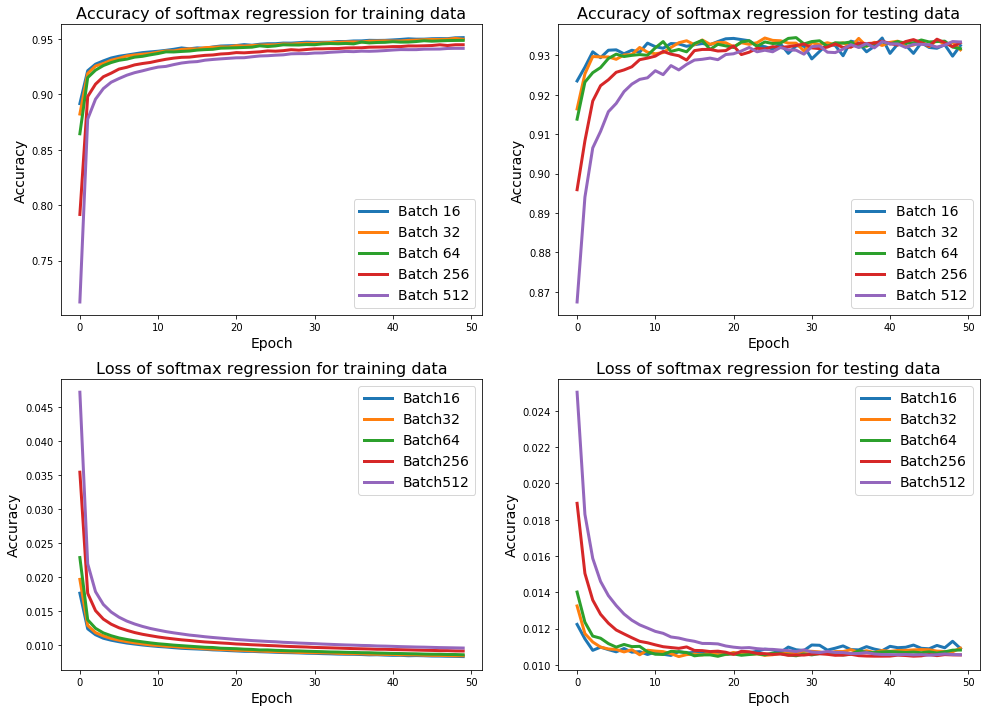

In [0]:
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
for i in range(len(batch_size)):
    plt.plot(history[i].epoch, history[i].history['accuracy'], lw=3, label='Batch '+str(batch_size[i]))
    plt.legend(fontsize=14)
    plt.title('Accuracy of softmax regression for training data', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)

plt.subplot(2, 2, 2)
for i in range(len(batch_size)):
    plt.plot(history[i].epoch, history[i].history['val_accuracy'], lw=3, label='Batch '+str(batch_size[i]))
    plt.legend(fontsize=14)
    plt.title('Accuracy of softmax regression for testing data', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)

plt.subplot(2, 2, 3)
for i in range(len(batch_size)):
    plt.plot(history[i].epoch, history[i].history['loss'], lw=3, label='Batch'+str(batch_size[i]))
    plt.legend(fontsize=14)
    plt.title('Loss of softmax regression for training data', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    
plt.subplot(2, 2, 4)
for i in range(len(batch_size)):
    plt.plot(history[i].epoch, history[i].history['val_loss'], lw=3, label='Batch'+str(batch_size[i]))
    plt.legend(fontsize=14)
    plt.title('Loss of softmax regression for testing data', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)

plt.tight_layout()

Nous pouvons remarquer que plus le batch est petit, plus la convergence est rapide mais plus les variations du taux de réussite de prédiction varie sur les échantillons de tests d'une étape à l'autre. Après un certain nombre de prédictions, la taille du batch n'a plus d'impact sur le taux de prédictions réussies sur les échantillons de tests mais les prédictions sur les échantillons d'entrainement sont meilleures avec un petit batch. Cependant, plus le batch est grand, plus les époques sont rapide ce qui est logique car on calcule moins souvent le gradient.
Comme nous pouvions nous y attendre, les résultats s'améliorent avec le nombre d'époques.


### <font color=darkred> Feed-Forward Neural Network (FFNN)</font>

The softmax regression you just trained is a linear model, with 7850 parameters. 
It is easy to fit, numerically stable, but might be too simple for some tasks. 
The idea behind neural networks is to have a nonlinear model, while keeping the nice features of linear ones. 
The idea is to keep parameters into linear functions, and link these small linear model using non linear operations.

A simple nonlinearity which is often used to do this is the rectified linear unit
$\text{ReLU}(x) = \max(0, x)$

The derivative of this function is very easy to compute, and it is parameter-free. If we stack models such as softmax regression and ReLUs, it is still very easy to compute the gradient using the chain rule, as the model is a combination of simple functions.

The backpropagation algorithm allows efficient computation of complex derivatives as long as the function is made of simple blocks with simple derivatives. 
This algorithm efficiency is based on data reuse: when working with parallel architectures such as GPUs, you want to minimize communication (data transfer) as it is very time consuming in comparison to the computing time.

**Question**

Create the graph for a fully connected feed-forward neural network with one hidden layer with 128 units and a relu activation function. 

In [0]:
model_ffnn = Sequential()

model_ffnn.add(Flatten(input_shape=input_shape))
model_ffnn.add(Dense(128, activation='relu', name='dense_Relu'))
model_ffnn.add(Dense(num_classes, activation='softmax'))

model_ffnn.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adagrad(),
    metrics=['accuracy']
)

model_ffnn.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_Relu (Dense)           (None, 128)               100480    
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [0]:
batch_size = 32
epochs = 50

# Run the train
history = model_ffnn.fit(x_train, y_train,
                         batch_size=batch_size,
                         epochs=epochs,
                         verbose=1,
                         validation_data=(x_test, y_test))
score = model_ffnn.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 5s 89us/step - loss: 0.2572 - accuracy: 0.9265 - val_loss: 0.1777 - val_accuracy: 0.9507
Epoch 2/50
60000/60000 [==============================] - 6s 96us/step - loss: 0.1623 - accuracy: 0.9545 - val_loss: 0.1473 - val_accuracy: 0.9591
Epoch 3/50
60000/60000 [==============================] - 6s 104us/step - loss: 0.1358 - accuracy: 0.9620 - val_loss: 0.1321 - val_accuracy: 0.9636
Epoch 4/50
60000/60000 [==============================] - 6s 95us/step - loss: 0.1195 - accuracy: 0.9672 - val_loss: 0.1209 - val_accuracy: 0.9653
Epoch 5/50
60000/60000 [==============================] - 6s 94us/step - loss: 0.1082 - accuracy: 0.9698 - val_loss: 0.1125 - val_accuracy: 0.9681
Epoch 6/50
60000/60000 [==============================] - 5s 83us/step - loss: 0.0996 - accuracy: 0.9727 - val_loss: 0.1068 - val_accuracy: 0.9682
Epoch 7/50
60000/60000 [==============================] - 5s 85us/s

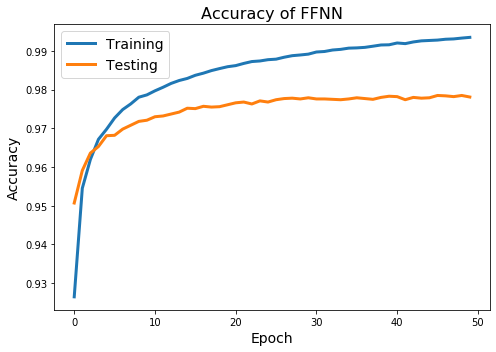

In [0]:
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['accuracy'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_accuracy'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Accuracy of FFNN', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.tight_layout()

Les résultats sont meilleurs d'environ 5% par rapport à une simple regression softmax sur les échantillons d'entraînements et de tests. Cela semble logique car le nombre de paramètres est 10 fois plus grand. De plus, nous pouvons voir que le taux de prédictions réussies augmente toujours sur l'échantillon d'entraînement mais il semble qu'il soit majoré à environ 97.8% sur l'échantillon de test. Sur l'échantillon d'entraînement le score augmente toujours car le réseau de neurones s'adapte à cet échantillon précis. On peut parler de surapprentissage.

In [0]:
def ffnn_model(nb_neuron):
    model_ffnn = Sequential()
    model_ffnn.add(Flatten(input_shape=input_shape))
    model_ffnn.add(Dense(nb_neuron, activation='relu', name='dense_Relu'))
    model_ffnn.add(Dense(num_classes, activation='softmax'))

    model_ffnn.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adagrad(),
    metrics=['accuracy']
    )
    
    return model_ffnn


parameters = {'batch_size': [16,64,256],
              'nb_neuron': [32,64,128],
              'epochs': [10,50,100]}

keras_model = KerasRegressor(build_fn = ffnn_model)

In [0]:
clf = GridSearchCV(keras_model, parameters, cv = 3)
clf.fit(x_train, y_train)

Epoch 1/10
40000/40000 [==============================] - 5s 132us/step - loss: 0.3764 - accuracy: 0.8968
Epoch 2/10
40000/40000 [==============================] - 5s 132us/step - loss: 0.2661 - accuracy: 0.9246
Epoch 3/10
40000/40000 [==============================] - 5s 131us/step - loss: 0.2411 - accuracy: 0.9329
Epoch 4/10
40000/40000 [==============================] - 5s 133us/step - loss: 0.2264 - accuracy: 0.9375
Epoch 5/10
40000/40000 [==============================] - 5s 132us/step - loss: 0.2154 - accuracy: 0.9398
Epoch 6/10
40000/40000 [==============================] - 5s 133us/step - loss: 0.2068 - accuracy: 0.9420
Epoch 7/10
40000/40000 [==============================] - 5s 130us/step - loss: 0.1996 - accuracy: 0.9440
Epoch 8/10
40000/40000 [==============================] - 5s 130us/step - loss: 0.1936 - accuracy: 0.9458
Epoch 9/10
40000/40000 [==============================] - 5s 129us/step - loss: 0.1884 - accuracy: 0.9473
Epoch 10/10
20000/20000 [=====================

40000/40000 [==============================] - 5s 123us/step - loss: 0.1270 - accuracy: 0.9648
Epoch 5/10
40000/40000 [==============================] - 5s 124us/step - loss: 0.1146 - accuracy: 0.9688
Epoch 6/10
40000/40000 [==============================] - 5s 125us/step - loss: 0.1048 - accuracy: 0.9715
Epoch 7/10
40000/40000 [==============================] - ETA: 0s - loss: 0.0972 - accuracy: 0.97 - 5s 125us/step - loss: 0.0973 - accuracy: 0.9733
Epoch 8/10
40000/40000 [==============================] - 6s 140us/step - loss: 0.0910 - accuracy: 0.9754
Epoch 9/10
40000/40000 [==============================] - 5s 124us/step - loss: 0.0855 - accuracy: 0.9765
Epoch 10/10
20000/20000 [==============================] - 2s 91us/step
Epoch 1/10
40000/40000 [==============================] - 5s 131us/step - loss: 0.2797 - accuracy: 0.9199
Epoch 2/10
40000/40000 [==============================] - 5s 129us/step - loss: 0.1691 - accuracy: 0.9523
Epoch 3/10
40000/40000 [=========================

40000/40000 [==============================] - 5s 128us/step - loss: 0.1227 - accuracy: 0.9660
Epoch 35/50
40000/40000 [==============================] - 5s 133us/step - loss: 0.1216 - accuracy: 0.9664
Epoch 36/50
40000/40000 [==============================] - 5s 128us/step - loss: 0.1206 - accuracy: 0.9662
Epoch 37/50
40000/40000 [==============================] - 5s 130us/step - loss: 0.1194 - accuracy: 0.9669
Epoch 38/50
40000/40000 [==============================] - 5s 127us/step - loss: 0.1184 - accuracy: 0.9671
Epoch 39/50
40000/40000 [==============================] - 5s 128us/step - loss: 0.1175 - accuracy: 0.9675
Epoch 40/50
40000/40000 [==============================] - 5s 132us/step - loss: 0.1166 - accuracy: 0.9673
Epoch 41/50
40000/40000 [==============================] - 5s 128us/step - loss: 0.1156 - accuracy: 0.9679
Epoch 42/50
40000/40000 [==============================] - 5s 127us/step - loss: 0.1148 - accuracy: 0.9679
Epoch 43/50
40000/40000 [========================

40000/40000 [==============================] - 5s 131us/step - loss: 0.0736 - accuracy: 0.9805
Epoch 35/50
40000/40000 [==============================] - 5s 128us/step - loss: 0.0725 - accuracy: 0.9809
Epoch 36/50
40000/40000 [==============================] - 5s 129us/step - loss: 0.0716 - accuracy: 0.9812
Epoch 37/50
40000/40000 [==============================] - 5s 134us/step - loss: 0.0706 - accuracy: 0.9817
Epoch 38/50
40000/40000 [==============================] - 5s 129us/step - loss: 0.0696 - accuracy: 0.9817
Epoch 39/50
40000/40000 [==============================] - 6s 139us/step - loss: 0.0689 - accuracy: 0.9822
Epoch 40/50
40000/40000 [==============================] - 5s 135us/step - loss: 0.0679 - accuracy: 0.9825
Epoch 41/50
40000/40000 [==============================] - 5s 128us/step - loss: 0.0671 - accuracy: 0.9826
Epoch 42/50
40000/40000 [==============================] - 5s 129us/step - loss: 0.0663 - accuracy: 0.9829
Epoch 43/50
40000/40000 [========================

40000/40000 [==============================] - 5s 129us/step - loss: 0.0393 - accuracy: 0.9914
Epoch 36/50
40000/40000 [==============================] - 5s 131us/step - loss: 0.0385 - accuracy: 0.9916
Epoch 37/50
40000/40000 [==============================] - 5s 128us/step - loss: 0.0378 - accuracy: 0.9916
Epoch 38/50
40000/40000 [==============================] - 5s 127us/step - loss: 0.0370 - accuracy: 0.9920
Epoch 39/50
40000/40000 [==============================] - 5s 128us/step - loss: 0.0363 - accuracy: 0.9921
Epoch 40/50
40000/40000 [==============================] - 5s 126us/step - loss: 0.0355 - accuracy: 0.9928
Epoch 41/50
40000/40000 [==============================] - 5s 125us/step - loss: 0.0349 - accuracy: 0.9928
Epoch 42/50
40000/40000 [==============================] - 5s 129us/step - loss: 0.0341 - accuracy: 0.9928
Epoch 43/50
40000/40000 [==============================] - 5s 129us/step - loss: 0.0335 - accuracy: 0.9930
Epoch 44/50
40000/40000 [========================

40000/40000 [==============================] - 5s 121us/step - loss: 0.1138 - accuracy: 0.9675
Epoch 36/100
40000/40000 [==============================] - 5s 122us/step - loss: 0.1129 - accuracy: 0.9679
Epoch 37/100
40000/40000 [==============================] - 5s 122us/step - loss: 0.1118 - accuracy: 0.9680
Epoch 38/100
40000/40000 [==============================] - 5s 122us/step - loss: 0.1110 - accuracy: 0.9683
Epoch 39/100
40000/40000 [==============================] - 5s 124us/step - loss: 0.1101 - accuracy: 0.9683
Epoch 40/100
40000/40000 [==============================] - 5s 122us/step - loss: 0.1092 - accuracy: 0.9686
Epoch 41/100
40000/40000 [==============================] - 5s 122us/step - loss: 0.1083 - accuracy: 0.9688
Epoch 42/100
40000/40000 [==============================] - 5s 121us/step - loss: 0.1075 - accuracy: 0.9692
Epoch 43/100
40000/40000 [==============================] - 5s 121us/step - loss: 0.1067 - accuracy: 0.9692
Epoch 44/100
40000/40000 [===============

Epoch 86/100
40000/40000 [==============================] - 5s 129us/step - loss: 0.1017 - accuracy: 0.9718
Epoch 87/100
40000/40000 [==============================] - 5s 127us/step - loss: 0.1013 - accuracy: 0.9715
Epoch 88/100
40000/40000 [==============================] - 5s 127us/step - loss: 0.1008 - accuracy: 0.9718
Epoch 89/100
40000/40000 [==============================] - 5s 128us/step - loss: 0.1002 - accuracy: 0.9719
Epoch 90/100
40000/40000 [==============================] - 5s 127us/step - loss: 0.0996 - accuracy: 0.9721
Epoch 91/100
40000/40000 [==============================] - 5s 128us/step - loss: 0.0991 - accuracy: 0.9722
Epoch 92/100
40000/40000 [==============================] - 5s 127us/step - loss: 0.0986 - accuracy: 0.9720
Epoch 93/100
40000/40000 [==============================] - 5s 128us/step - loss: 0.0980 - accuracy: 0.9725
Epoch 94/100
40000/40000 [==============================] - 5s 128us/step - loss: 0.0975 - accuracy: 0.9725
Epoch 95/100
40000/40000 [==

40000/40000 [==============================] - 5s 126us/step - loss: 0.0689 - accuracy: 0.9819
Epoch 37/100
40000/40000 [==============================] - 5s 125us/step - loss: 0.0680 - accuracy: 0.9826
Epoch 38/100
40000/40000 [==============================] - 5s 129us/step - loss: 0.0671 - accuracy: 0.9829
Epoch 39/100
40000/40000 [==============================] - 5s 129us/step - loss: 0.0662 - accuracy: 0.9830
Epoch 40/100
40000/40000 [==============================] - 5s 126us/step - loss: 0.0654 - accuracy: 0.9834
Epoch 41/100
40000/40000 [==============================] - 5s 126us/step - loss: 0.0646 - accuracy: 0.9833
Epoch 42/100
40000/40000 [==============================] - 5s 124us/step - loss: 0.0638 - accuracy: 0.98360s - loss: 0
Epoch 43/100
40000/40000 [==============================] - 5s 124us/step - loss: 0.0631 - accuracy: 0.9839
Epoch 44/100
40000/40000 [==============================] - 5s 125us/step - loss: 0.0622 - accuracy: 0.9841
Epoch 45/100
40000/40000 [===

Epoch 86/100
40000/40000 [==============================] - 5s 127us/step - loss: 0.0418 - accuracy: 0.9907
Epoch 87/100
40000/40000 [==============================] - 5s 131us/step - loss: 0.0414 - accuracy: 0.9907
Epoch 88/100
40000/40000 [==============================] - 5s 136us/step - loss: 0.0411 - accuracy: 0.9912
Epoch 89/100
40000/40000 [==============================] - 5s 132us/step - loss: 0.0408 - accuracy: 0.9910
Epoch 90/100
40000/40000 [==============================] - 5s 130us/step - loss: 0.0404 - accuracy: 0.9915
Epoch 91/100
40000/40000 [==============================] - 5s 133us/step - loss: 0.0401 - accuracy: 0.9912
Epoch 92/100
40000/40000 [==============================] - 5s 126us/step - loss: 0.0399 - accuracy: 0.9914
Epoch 93/100
40000/40000 [==============================] - 5s 127us/step - loss: 0.0396 - accuracy: 0.9913
Epoch 94/100
40000/40000 [==============================] - 5s 128us/step - loss: 0.0393 - accuracy: 0.9916
Epoch 95/100
40000/40000 [==

Epoch 61/100
40000/40000 [==============================] - 5s 131us/step - loss: 0.0236 - accuracy: 0.9960
Epoch 62/100
40000/40000 [==============================] - 5s 129us/step - loss: 0.0233 - accuracy: 0.9961
Epoch 63/100
40000/40000 [==============================] - 5s 125us/step - loss: 0.0229 - accuracy: 0.9962
Epoch 64/100
40000/40000 [==============================] - 5s 126us/step - loss: 0.0226 - accuracy: 0.9964
Epoch 65/100
40000/40000 [==============================] - 5s 127us/step - loss: 0.0223 - accuracy: 0.99640s - loss: 0.0222 - accu
Epoch 66/100
40000/40000 [==============================] - 5s 130us/step - loss: 0.0219 - accuracy: 0.9966
Epoch 67/100
40000/40000 [==============================] - 5s 128us/step - loss: 0.0216 - accuracy: 0.9968
Epoch 68/100
40000/40000 [==============================] - 5s 127us/step - loss: 0.0213 - accuracy: 0.9968
Epoch 69/100
40000/40000 [==============================] - 5s 132us/step - loss: 0.0210 - accuracy: 0.9968
Epoc

40000/40000 [==============================] - 5s 129us/step - loss: 0.0821 - accuracy: 0.9786
Epoch 11/100
40000/40000 [==============================] - 5s 125us/step - loss: 0.0784 - accuracy: 0.9790
Epoch 12/100
40000/40000 [==============================] - 5s 126us/step - loss: 0.0747 - accuracy: 0.9802
Epoch 13/100
40000/40000 [==============================] - 5s 131us/step - loss: 0.0715 - accuracy: 0.9817
Epoch 14/100
40000/40000 [==============================] - 5s 128us/step - loss: 0.0687 - accuracy: 0.9823
Epoch 15/100
40000/40000 [==============================] - 5s 129us/step - loss: 0.0659 - accuracy: 0.9832
Epoch 16/100
40000/40000 [==============================] - 5s 131us/step - loss: 0.0635 - accuracy: 0.9839
Epoch 17/100
40000/40000 [==============================] - 5s 132us/step - loss: 0.0614 - accuracy: 0.9846
Epoch 18/100
40000/40000 [==============================] - 5s 129us/step - loss: 0.0593 - accuracy: 0.9850
Epoch 19/100
40000/40000 [===============

Epoch 86/100
40000/40000 [==============================] - 5s 125us/step - loss: 0.0176 - accuracy: 0.9980
Epoch 87/100
40000/40000 [==============================] - 5s 129us/step - loss: 0.0174 - accuracy: 0.99790s - loss: 0.0175 
Epoch 88/100
40000/40000 [==============================] - 5s 130us/step - loss: 0.0172 - accuracy: 0.9981
Epoch 89/100
40000/40000 [==============================] - 5s 131us/step - loss: 0.0170 - accuracy: 0.9981
Epoch 90/100
40000/40000 [==============================] - 5s 130us/step - loss: 0.0168 - accuracy: 0.9980
Epoch 91/100
40000/40000 [==============================] - 5s 127us/step - loss: 0.0167 - accuracy: 0.9983
Epoch 92/100
40000/40000 [==============================] - 5s 130us/step - loss: 0.0164 - accuracy: 0.9983
Epoch 93/100
40000/40000 [==============================] - 5s 125us/step - loss: 0.0163 - accuracy: 0.9984
Epoch 94/100
40000/40000 [==============================] - 5s 128us/step - loss: 0.0161 - accuracy: 0.9984
Epoch 95/1

40000/40000 [==============================] - 1s 33us/step - loss: 0.1207 - accuracy: 0.9664
Epoch 44/50
40000/40000 [==============================] - 1s 34us/step - loss: 0.1198 - accuracy: 0.9664
Epoch 45/50
40000/40000 [==============================] - 1s 32us/step - loss: 0.1189 - accuracy: 0.9670
Epoch 46/50
40000/40000 [==============================] - 1s 33us/step - loss: 0.1179 - accuracy: 0.9669
Epoch 47/50
40000/40000 [==============================] - 1s 34us/step - loss: 0.1171 - accuracy: 0.9674
Epoch 48/50
40000/40000 [==============================] - 1s 33us/step - loss: 0.1162 - accuracy: 0.9671
Epoch 49/50
40000/40000 [==============================] - 1s 34us/step - loss: 0.1154 - accuracy: 0.9679
Epoch 50/50
20000/20000 [==============================] - 0s 25us/step
Epoch 1/50
40000/40000 [==============================] - 1s 35us/step - loss: 0.3951 - accuracy: 0.8928
Epoch 2/50
40000/40000 [==============================] - 1s 33us/step - loss: 0.2729 - accur

40000/40000 [==============================] - 1s 33us/step - loss: 0.1515 - accuracy: 0.9569
Epoch 20/50
40000/40000 [==============================] - 1s 32us/step - loss: 0.1492 - accuracy: 0.9581
Epoch 21/50
40000/40000 [==============================] - 1s 34us/step - loss: 0.1472 - accuracy: 0.9584
Epoch 22/50
40000/40000 [==============================] - 1s 33us/step - loss: 0.1452 - accuracy: 0.9589
Epoch 23/50
40000/40000 [==============================] - 1s 34us/step - loss: 0.1432 - accuracy: 0.9595
Epoch 24/50
40000/40000 [==============================] - 1s 35us/step - loss: 0.1413 - accuracy: 0.9600
Epoch 25/50
40000/40000 [==============================] - 1s 34us/step - loss: 0.1396 - accuracy: 0.9607
Epoch 26/50
40000/40000 [==============================] - 1s 35us/step - loss: 0.1379 - accuracy: 0.9611
Epoch 27/50
40000/40000 [==============================] - 1s 35us/step - loss: 0.1363 - accuracy: 0.9614
Epoch 28/50
40000/40000 [==============================] -

40000/40000 [==============================] - 1s 34us/step - loss: 0.1026 - accuracy: 0.9718
Epoch 22/50
40000/40000 [==============================] - 1s 34us/step - loss: 0.1006 - accuracy: 0.9726
Epoch 23/50
40000/40000 [==============================] - 1s 34us/step - loss: 0.0988 - accuracy: 0.9734
Epoch 24/50
40000/40000 [==============================] - 1s 32us/step - loss: 0.0971 - accuracy: 0.9736
Epoch 25/50
40000/40000 [==============================] - 1s 34us/step - loss: 0.0954 - accuracy: 0.9738
Epoch 26/50
40000/40000 [==============================] - 1s 34us/step - loss: 0.0939 - accuracy: 0.9740
Epoch 27/50
40000/40000 [==============================] - 1s 35us/step - loss: 0.0922 - accuracy: 0.9747
Epoch 28/50
40000/40000 [==============================] - 1s 34us/step - loss: 0.0908 - accuracy: 0.9756
Epoch 29/50
40000/40000 [==============================] - 1s 34us/step - loss: 0.0893 - accuracy: 0.9757
Epoch 30/50
40000/40000 [==============================] -

40000/40000 [==============================] - 1s 34us/step - loss: 0.0535 - accuracy: 0.9867
Epoch 24/50
40000/40000 [==============================] - 1s 34us/step - loss: 0.0520 - accuracy: 0.9872
Epoch 25/50
40000/40000 [==============================] - 1s 34us/step - loss: 0.0506 - accuracy: 0.9877
Epoch 26/50
40000/40000 [==============================] - 1s 34us/step - loss: 0.0492 - accuracy: 0.9882
Epoch 27/50
40000/40000 [==============================] - 1s 34us/step - loss: 0.0479 - accuracy: 0.9888
Epoch 28/50
40000/40000 [==============================] - 1s 33us/step - loss: 0.0467 - accuracy: 0.9891
Epoch 29/50
40000/40000 [==============================] - 1s 33us/step - loss: 0.0458 - accuracy: 0.9893 0s - loss: 0.0451 - accu
Epoch 30/50
40000/40000 [==============================] - 1s 33us/step - loss: 0.0446 - accuracy: 0.9898
Epoch 31/50
40000/40000 [==============================] - 1s 34us/step - loss: 0.0436 - accuracy: 0.9901
Epoch 32/50
40000/40000 [========

40000/40000 [==============================] - 1s 35us/step - loss: 0.1372 - accuracy: 0.9621
Epoch 26/100
40000/40000 [==============================] - 1s 35us/step - loss: 0.1355 - accuracy: 0.9627
Epoch 27/100
40000/40000 [==============================] - 1s 34us/step - loss: 0.1337 - accuracy: 0.9631
Epoch 28/100
40000/40000 [==============================] - 1s 35us/step - loss: 0.1321 - accuracy: 0.9635
Epoch 29/100
40000/40000 [==============================] - 1s 35us/step - loss: 0.1305 - accuracy: 0.9641
Epoch 30/100
40000/40000 [==============================] - 1s 35us/step - loss: 0.1291 - accuracy: 0.9648
Epoch 31/100
40000/40000 [==============================] - 1s 34us/step - loss: 0.1276 - accuracy: 0.9646
Epoch 32/100
40000/40000 [==============================] - 1s 34us/step - loss: 0.1262 - accuracy: 0.9651
Epoch 33/100
40000/40000 [==============================] - 1s 35us/step - loss: 0.1249 - accuracy: 0.9657
Epoch 34/100
40000/40000 [========================

40000/40000 [==============================] - 1s 35us/step - loss: 0.0953 - accuracy: 0.9735
Epoch 78/100
40000/40000 [==============================] - 1s 34us/step - loss: 0.0949 - accuracy: 0.9738
Epoch 79/100
40000/40000 [==============================] - 1s 34us/step - loss: 0.0944 - accuracy: 0.9740
Epoch 80/100
40000/40000 [==============================] - 1s 34us/step - loss: 0.0940 - accuracy: 0.9740
Epoch 81/100
40000/40000 [==============================] - 1s 34us/step - loss: 0.0936 - accuracy: 0.9742
Epoch 82/100
40000/40000 [==============================] - 1s 35us/step - loss: 0.0932 - accuracy: 0.9743
Epoch 83/100
40000/40000 [==============================] - 1s 34us/step - loss: 0.0928 - accuracy: 0.9744
Epoch 84/100
40000/40000 [==============================] - 1s 35us/step - loss: 0.0923 - accuracy: 0.9746
Epoch 85/100
40000/40000 [==============================] - 1s 34us/step - loss: 0.0920 - accuracy: 0.9744
Epoch 86/100
40000/40000 [========================

Epoch 53/100
40000/40000 [==============================] - 1s 35us/step - loss: 0.0610 - accuracy: 0.9844
Epoch 54/100
40000/40000 [==============================] - 1s 35us/step - loss: 0.0604 - accuracy: 0.9845
Epoch 55/100
40000/40000 [==============================] - 1s 34us/step - loss: 0.0597 - accuracy: 0.9846
Epoch 56/100
40000/40000 [==============================] - 1s 35us/step - loss: 0.0592 - accuracy: 0.9851
Epoch 57/100
40000/40000 [==============================] - 1s 35us/step - loss: 0.0586 - accuracy: 0.9849
Epoch 58/100
40000/40000 [==============================] - 1s 35us/step - loss: 0.0580 - accuracy: 0.9852
Epoch 59/100
40000/40000 [==============================] - 1s 35us/step - loss: 0.0574 - accuracy: 0.9853
Epoch 60/100
40000/40000 [==============================] - 1s 35us/step - loss: 0.0569 - accuracy: 0.9858
Epoch 61/100
40000/40000 [==============================] - 1s 36us/step - loss: 0.0564 - accuracy: 0.9857
Epoch 62/100
40000/40000 [===========

40000/40000 [==============================] - 1s 35us/step - loss: 0.0817 - accuracy: 0.9779
Epoch 30/100
40000/40000 [==============================] - 1s 34us/step - loss: 0.0804 - accuracy: 0.9783
Epoch 31/100
40000/40000 [==============================] - 1s 34us/step - loss: 0.0792 - accuracy: 0.9788
Epoch 32/100
40000/40000 [==============================] - 1s 33us/step - loss: 0.0780 - accuracy: 0.9789
Epoch 33/100
40000/40000 [==============================] - 1s 34us/step - loss: 0.0769 - accuracy: 0.9794
Epoch 34/100
40000/40000 [==============================] - 1s 34us/step - loss: 0.0758 - accuracy: 0.9792
Epoch 35/100
40000/40000 [==============================] - 1s 34us/step - loss: 0.0747 - accuracy: 0.9800
Epoch 36/100
40000/40000 [==============================] - 1s 33us/step - loss: 0.0739 - accuracy: 0.9804
Epoch 37/100
40000/40000 [==============================] - 1s 34us/step - loss: 0.0728 - accuracy: 0.9803
Epoch 38/100
40000/40000 [========================

40000/40000 [==============================] - 1s 34us/step - loss: 0.0525 - accuracy: 0.9878
Epoch 82/100
40000/40000 [==============================] - 1s 35us/step - loss: 0.0521 - accuracy: 0.9878
Epoch 83/100
40000/40000 [==============================] - 1s 33us/step - loss: 0.0518 - accuracy: 0.9879
Epoch 84/100
40000/40000 [==============================] - 1s 35us/step - loss: 0.0514 - accuracy: 0.9882
Epoch 85/100
40000/40000 [==============================] - 1s 35us/step - loss: 0.0510 - accuracy: 0.9881
Epoch 86/100
40000/40000 [==============================] - 1s 35us/step - loss: 0.0506 - accuracy: 0.9882
Epoch 87/100
40000/40000 [==============================] - 1s 35us/step - loss: 0.0503 - accuracy: 0.9885
Epoch 88/100
40000/40000 [==============================] - 1s 35us/step - loss: 0.0500 - accuracy: 0.9885
Epoch 89/100
40000/40000 [==============================] - 1s 34us/step - loss: 0.0496 - accuracy: 0.9884
Epoch 90/100
40000/40000 [========================

40000/40000 [==============================] - 1s 36us/step - loss: 0.0278 - accuracy: 0.9947
Epoch 58/100
40000/40000 [==============================] - 1s 34us/step - loss: 0.0274 - accuracy: 0.9948
Epoch 59/100
40000/40000 [==============================] - 1s 33us/step - loss: 0.0270 - accuracy: 0.9951
Epoch 60/100
40000/40000 [==============================] - 1s 33us/step - loss: 0.0265 - accuracy: 0.9951
Epoch 61/100
40000/40000 [==============================] - 1s 32us/step - loss: 0.0261 - accuracy: 0.9951
Epoch 62/100
40000/40000 [==============================] - 1s 33us/step - loss: 0.0257 - accuracy: 0.9953
Epoch 63/100
40000/40000 [==============================] - 1s 33us/step - loss: 0.0254 - accuracy: 0.9955
Epoch 64/100
40000/40000 [==============================] - 1s 33us/step - loss: 0.0250 - accuracy: 0.9958
Epoch 65/100
40000/40000 [==============================] - 1s 33us/step - loss: 0.0247 - accuracy: 0.9959
Epoch 66/100
40000/40000 [========================

40000/40000 [==============================] - 1s 35us/step - loss: 0.0947 - accuracy: 0.9738
Epoch 10/100
40000/40000 [==============================] - 1s 35us/step - loss: 0.0898 - accuracy: 0.9755
Epoch 11/100
40000/40000 [==============================] - 1s 34us/step - loss: 0.0853 - accuracy: 0.9772
Epoch 12/100
40000/40000 [==============================] - 1s 34us/step - loss: 0.0816 - accuracy: 0.9783
Epoch 13/100
40000/40000 [==============================] - 1s 34us/step - loss: 0.0781 - accuracy: 0.9795
Epoch 14/100
40000/40000 [==============================] - 1s 33us/step - loss: 0.0749 - accuracy: 0.9803
Epoch 15/100
40000/40000 [==============================] - 1s 35us/step - loss: 0.0721 - accuracy: 0.9815
Epoch 16/100
40000/40000 [==============================] - 1s 35us/step - loss: 0.0695 - accuracy: 0.9817
Epoch 17/100
40000/40000 [==============================] - 1s 34us/step - loss: 0.0671 - accuracy: 0.9826
Epoch 18/100
40000/40000 [========================

40000/40000 [==============================] - 0s 10us/step - loss: 0.1492 - accuracy: 0.9580
Epoch 10/10
20000/20000 [==============================] - 0s 8us/step
Epoch 1/10
40000/40000 [==============================] - 0s 11us/step - loss: 0.3889 - accuracy: 0.8886
Epoch 2/10
40000/40000 [==============================] - 0s 10us/step - loss: 0.2212 - accuracy: 0.9387
Epoch 3/10
40000/40000 [==============================] - 0s 9us/step - loss: 0.1844 - accuracy: 0.9489
Epoch 4/10
40000/40000 [==============================] - 0s 9us/step - loss: 0.1634 - accuracy: 0.9541
Epoch 5/10
40000/40000 [==============================] - 0s 9us/step - loss: 0.1481 - accuracy: 0.9589
Epoch 6/10
40000/40000 [==============================] - 0s 9us/step - loss: 0.1366 - accuracy: 0.9623
Epoch 7/10
40000/40000 [==============================] - 0s 9us/step - loss: 0.1274 - accuracy: 0.9648
Epoch 8/10
40000/40000 [==============================] - 0s 9us/step - loss: 0.1198 - accuracy: 0.9676
E

40000/40000 [==============================] - 0s 10us/step - loss: 0.1257 - accuracy: 0.9652
Epoch 46/50
40000/40000 [==============================] - 0s 9us/step - loss: 0.1248 - accuracy: 0.9655
Epoch 47/50
40000/40000 [==============================] - 0s 9us/step - loss: 0.1240 - accuracy: 0.9659
Epoch 48/50
40000/40000 [==============================] - 0s 10us/step - loss: 0.1231 - accuracy: 0.9664
Epoch 49/50
40000/40000 [==============================] - 0s 9us/step - loss: 0.1223 - accuracy: 0.9661
Epoch 50/50
20000/20000 [==============================] - 0s 8us/step
Epoch 1/50
40000/40000 [==============================] - 0s 11us/step - loss: 0.5002 - accuracy: 0.8675
Epoch 2/50
40000/40000 [==============================] - 0s 9us/step - loss: 0.3068 - accuracy: 0.9157
Epoch 3/50
40000/40000 [==============================] - 0s 9us/step - loss: 0.2721 - accuracy: 0.9245
Epoch 4/50
40000/40000 [==============================] - 0s 10us/step - loss: 0.2526 - accuracy: 0.9

40000/40000 [==============================] - 0s 9us/step - loss: 0.0791 - accuracy: 0.9793
Epoch 49/50
40000/40000 [==============================] - 0s 9us/step - loss: 0.0783 - accuracy: 0.9791
Epoch 50/50
20000/20000 [==============================] - 0s 7us/step
Epoch 1/50
40000/40000 [==============================] - 0s 11us/step - loss: 0.4416 - accuracy: 0.8776
Epoch 2/50
40000/40000 [==============================] - 0s 9us/step - loss: 0.2641 - accuracy: 0.9277
Epoch 3/50
40000/40000 [==============================] - 0s 10us/step - loss: 0.2292 - accuracy: 0.9366
Epoch 4/50
40000/40000 [==============================] - 0s 10us/step - loss: 0.2072 - accuracy: 0.9433
Epoch 5/50
40000/40000 [==============================] - 0s 10us/step - loss: 0.1922 - accuracy: 0.9470
Epoch 6/50
40000/40000 [==============================] - 0s 9us/step - loss: 0.1798 - accuracy: 0.9507
Epoch 7/50
40000/40000 [==============================] - 0s 9us/step - loss: 0.1705 - accuracy: 0.9527

40000/40000 [==============================] - ETA: 0s - loss: 0.1110 - accuracy: 0.96 - 0s 9us/step - loss: 0.1098 - accuracy: 0.9697
Epoch 26/50
40000/40000 [==============================] - 0s 9us/step - loss: 0.1081 - accuracy: 0.9704
Epoch 27/50
40000/40000 [==============================] - 0s 9us/step - loss: 0.1063 - accuracy: 0.9714
Epoch 28/50
40000/40000 [==============================] - 0s 9us/step - loss: 0.1047 - accuracy: 0.9715
Epoch 29/50
40000/40000 [==============================] - 0s 9us/step - loss: 0.1030 - accuracy: 0.9726
Epoch 30/50
40000/40000 [==============================] - 0s 9us/step - loss: 0.1015 - accuracy: 0.9724
Epoch 31/50
40000/40000 [==============================] - 0s 9us/step - loss: 0.1001 - accuracy: 0.9730
Epoch 32/50
40000/40000 [==============================] - 0s 9us/step - loss: 0.0986 - accuracy: 0.9733
Epoch 33/50
40000/40000 [==============================] - 0s 9us/step - loss: 0.0972 - accuracy: 0.9732
Epoch 34/50
40000/40000 [

40000/40000 [==============================] - 0s 10us/step - loss: 0.0567 - accuracy: 0.9862
Epoch 29/50
40000/40000 [==============================] - 0s 10us/step - loss: 0.0553 - accuracy: 0.9862
Epoch 30/50
40000/40000 [==============================] - 0s 9us/step - loss: 0.0540 - accuracy: 0.9866
Epoch 31/50
40000/40000 [==============================] - 0s 10us/step - loss: 0.0528 - accuracy: 0.9870
Epoch 32/50
40000/40000 [==============================] - 0s 10us/step - loss: 0.0516 - accuracy: 0.9877
Epoch 33/50
40000/40000 [==============================] - 0s 10us/step - loss: 0.0505 - accuracy: 0.9879
Epoch 34/50
40000/40000 [==============================] - 0s 10us/step - loss: 0.0495 - accuracy: 0.9878
Epoch 35/50
40000/40000 [==============================] - 0s 10us/step - loss: 0.0485 - accuracy: 0.9883
Epoch 36/50
40000/40000 [==============================] - 0s 10us/step - loss: 0.0475 - accuracy: 0.9887
Epoch 37/50
40000/40000 [==============================] - 

40000/40000 [==============================] - 0s 10us/step - loss: 0.1358 - accuracy: 0.9625
Epoch 31/100
40000/40000 [==============================] - 0s 10us/step - loss: 0.1343 - accuracy: 0.9627
Epoch 32/100
40000/40000 [==============================] - 0s 10us/step - loss: 0.1329 - accuracy: 0.9633
Epoch 33/100
40000/40000 [==============================] - 0s 10us/step - loss: 0.1315 - accuracy: 0.9639
Epoch 34/100
40000/40000 [==============================] - 0s 10us/step - loss: 0.1303 - accuracy: 0.9640
Epoch 35/100
40000/40000 [==============================] - 0s 10us/step - loss: 0.1290 - accuracy: 0.9649
Epoch 36/100
40000/40000 [==============================] - 0s 10us/step - loss: 0.1279 - accuracy: 0.9644
Epoch 37/100
40000/40000 [==============================] - 0s 10us/step - loss: 0.1268 - accuracy: 0.9652
Epoch 38/100
40000/40000 [==============================] - 0s 10us/step - loss: 0.1256 - accuracy: 0.9656
Epoch 39/100
40000/40000 [========================

40000/40000 [==============================] - 0s 9us/step - loss: 0.1055 - accuracy: 0.9709
Epoch 84/100
40000/40000 [==============================] - 0s 9us/step - loss: 0.1050 - accuracy: 0.9711
Epoch 85/100
40000/40000 [==============================] - 0s 9us/step - loss: 0.1044 - accuracy: 0.9710
Epoch 86/100
40000/40000 [==============================] - 0s 9us/step - loss: 0.1040 - accuracy: 0.9712
Epoch 87/100
40000/40000 [==============================] - 0s 9us/step - loss: 0.1035 - accuracy: 0.9712
Epoch 88/100
40000/40000 [==============================] - 0s 9us/step - loss: 0.1030 - accuracy: 0.9714
Epoch 89/100
40000/40000 [==============================] - 0s 9us/step - loss: 0.1026 - accuracy: 0.9718
Epoch 90/100
40000/40000 [==============================] - 0s 9us/step - loss: 0.1021 - accuracy: 0.9718
Epoch 91/100
40000/40000 [==============================] - 0s 9us/step - loss: 0.1017 - accuracy: 0.9719
Epoch 92/100
40000/40000 [==============================] -

40000/40000 [==============================] - 0s 10us/step - loss: 0.0903 - accuracy: 0.9752
Epoch 36/100
40000/40000 [==============================] - 0s 10us/step - loss: 0.0890 - accuracy: 0.9756
Epoch 37/100
40000/40000 [==============================] - 0s 10us/step - loss: 0.0878 - accuracy: 0.9762
Epoch 38/100
40000/40000 [==============================] - 0s 10us/step - loss: 0.0865 - accuracy: 0.9766
Epoch 39/100
40000/40000 [==============================] - 0s 9us/step - loss: 0.0854 - accuracy: 0.9766
Epoch 40/100
40000/40000 [==============================] - 0s 10us/step - loss: 0.0844 - accuracy: 0.9771
Epoch 41/100
40000/40000 [==============================] - 0s 10us/step - loss: 0.0832 - accuracy: 0.9775
Epoch 42/100
40000/40000 [==============================] - 0s 9us/step - loss: 0.0822 - accuracy: 0.9774
Epoch 43/100
40000/40000 [==============================] - 0s 10us/step - loss: 0.0811 - accuracy: 0.9780
Epoch 44/100
40000/40000 [==========================

40000/40000 [==============================] - 0s 9us/step - loss: 0.0475 - accuracy: 0.9883
Epoch 89/100
40000/40000 [==============================] - 0s 9us/step - loss: 0.0471 - accuracy: 0.9887
Epoch 90/100
40000/40000 [==============================] - 0s 9us/step - loss: 0.0468 - accuracy: 0.9887
Epoch 91/100
40000/40000 [==============================] - 0s 9us/step - loss: 0.0464 - accuracy: 0.9887
Epoch 92/100
40000/40000 [==============================] - 0s 9us/step - loss: 0.0460 - accuracy: 0.9890
Epoch 93/100
40000/40000 [==============================] - 0s 9us/step - loss: 0.0457 - accuracy: 0.9891
Epoch 94/100
40000/40000 [==============================] - 0s 9us/step - loss: 0.0454 - accuracy: 0.9891
Epoch 95/100
40000/40000 [==============================] - 0s 9us/step - loss: 0.0451 - accuracy: 0.9891
Epoch 96/100
40000/40000 [==============================] - 0s 9us/step - loss: 0.0448 - accuracy: 0.9893
Epoch 97/100
40000/40000 [==============================] -

40000/40000 [==============================] - 0s 9us/step - loss: 0.0444 - accuracy: 0.9896
Epoch 41/100
40000/40000 [==============================] - 0s 9us/step - loss: 0.0435 - accuracy: 0.9900
Epoch 42/100
40000/40000 [==============================] - 0s 10us/step - loss: 0.0427 - accuracy: 0.9904
Epoch 43/100
40000/40000 [==============================] - 0s 9us/step - loss: 0.0419 - accuracy: 0.9904
Epoch 44/100
40000/40000 [==============================] - 0s 10us/step - loss: 0.0411 - accuracy: 0.9909
Epoch 45/100
40000/40000 [==============================] - 0s 9us/step - loss: 0.0404 - accuracy: 0.9909
Epoch 46/100
40000/40000 [==============================] - 0s 9us/step - loss: 0.0397 - accuracy: 0.9913
Epoch 47/100
40000/40000 [==============================] - 0s 9us/step - loss: 0.0389 - accuracy: 0.9916
Epoch 48/100
40000/40000 [==============================] - 0s 9us/step - loss: 0.0383 - accuracy: 0.9918
Epoch 49/100
40000/40000 [==============================]

40000/40000 [==============================] - 0s 9us/step - loss: 0.0229 - accuracy: 0.9965
Epoch 94/100
40000/40000 [==============================] - 0s 9us/step - loss: 0.0227 - accuracy: 0.9966
Epoch 95/100
40000/40000 [==============================] - 0s 10us/step - loss: 0.0224 - accuracy: 0.9967
Epoch 96/100
40000/40000 [==============================] - 0s 9us/step - loss: 0.0222 - accuracy: 0.9966
Epoch 97/100
40000/40000 [==============================] - 0s 9us/step - loss: 0.0220 - accuracy: 0.9966
Epoch 98/100
40000/40000 [==============================] - 0s 10us/step - loss: 0.0217 - accuracy: 0.9968
Epoch 99/100
40000/40000 [==============================] - 0s 9us/step - loss: 0.0215 - accuracy: 0.9967
Epoch 100/100
20000/20000 [==============================] - 0s 8us/step
Epoch 1/50
60000/60000 [==============================] - 2s 35us/step - loss: 0.2757 - accuracy: 0.9221
Epoch 2/50
60000/60000 [==============================] - 2s 32us/step - loss: 0.1703 - acc

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x00000172F19AAA88>,
             iid='warn', n_jobs=None,
             param_grid={'batch_size': [16, 64, 256], 'epochs': [10, 50, 100],
                         'nb_neuron': [32, 64, 128]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [0]:
print(clf.best_params_)
best1=clf.best_params_

{'batch_size': 64, 'epochs': 50, 'nb_neuron': 128}


In [0]:
history1=ffnn_model(best1['nb_neuron']).fit(x_train, y_train,
                        batch_size=best1['batch_size'],
                        epochs=best1['epochs'],
                        verbose=1,
                        validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 38us/step - loss: 0.2745 - accuracy: 0.9222 - val_loss: 0.1845 - val_accuracy: 0.9478
Epoch 2/50
60000/60000 [==============================] - 2s 39us/step - loss: 0.1713 - accuracy: 0.9518 - val_loss: 0.1538 - val_accuracy: 0.9557
Epoch 3/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.1446 - accuracy: 0.9597 - val_loss: 0.1363 - val_accuracy: 0.9608
Epoch 4/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.1283 - accuracy: 0.9645 - val_loss: 0.1267 - val_accuracy: 0.9614
Epoch 5/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.1171 - accuracy: 0.9673 - val_loss: 0.1194 - val_accuracy: 0.9643
Epoch 6/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.1078 - accuracy: 0.9704 - val_loss: 0.1130 - val_accuracy: 0.9664
Epoch 7/50
60000/60000 [==============================] - 2s 37us/st

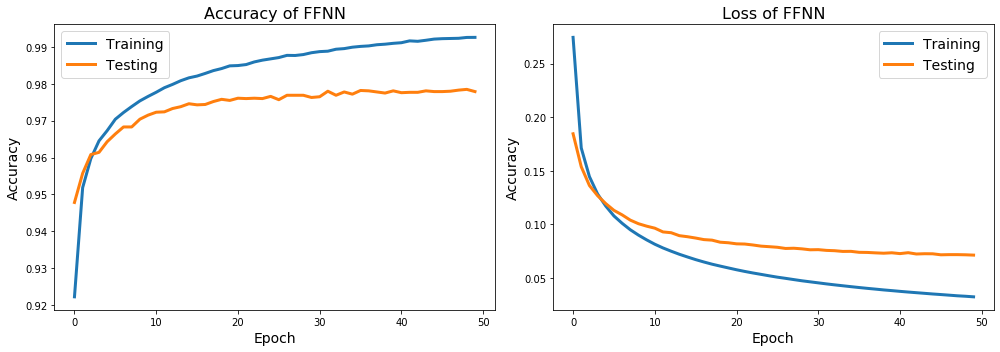

In [0]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history1.epoch, history1.history['accuracy'], lw=3, label='Training')
plt.plot(history1.epoch, history1.history['val_accuracy'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Accuracy of FFNN', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(history1.epoch, history1.history['loss'], lw=3, label='Training')
plt.plot(history1.epoch, history1.history['val_loss'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Loss of FFNN', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

plt.tight_layout()

Nous avons réalisé une validation croisée en faisant varier le nombre d'époques, la taille du batch et le nombre de neurones de la couche cachée. Nous pouvons voir que les résultats optimaux sont une taille de batch de 64, un nombre d'époques de 50 et un nombre de neurones de 128 dans la couche cachée. Ce choix pour le nombre de neurones dans la couche cachée peut nous sembler logique car c'est ce choix qui permet d'avoir le plus grand nombre de paramètres. Ce choix pour le nombre d'époque est étonnant car on pourrait se dire que plus le réseau est entrainé, meilleur il sera. Il y a donc peut-être un sur-apprentissage (des résultats qui ne font que croitre sur l'échantillon d'entrainement et des résultats qui décroissent sur l'échantillon de test) lorsque le nombre d'époque est trop grand par rapport à la taille du dataset. 
Nous obtenons quasiment les mêmes résultats par rapport à sans la validation croisée car les paramètres optimaux sont presque les mêmes que ceux qu'on avait mis de base.

In [0]:
clf2 = RandomizedSearchCV(keras_model, parameters, cv = 3,n_iter=10)
clf2.fit(x_train, y_train)

Epoch 1/100
40000/40000 [==============================] - 2s 52us/step - loss: 0.4119 - accuracy: 0.8867
Epoch 2/100
40000/40000 [==============================] - 1s 33us/step - loss: 0.2773 - accuracy: 0.9228
Epoch 3/100
40000/40000 [==============================] - 1s 32us/step - loss: 0.2450 - accuracy: 0.9316
Epoch 4/100
40000/40000 [==============================] - 1s 32us/step - loss: 0.2251 - accuracy: 0.9375
Epoch 5/100
40000/40000 [==============================] - 1s 32us/step - loss: 0.2113 - accuracy: 0.9415
Epoch 6/100
40000/40000 [==============================] - 1s 32us/step - loss: 0.2007 - accuracy: 0.9438
Epoch 7/100
40000/40000 [==============================] - 1s 31us/step - loss: 0.1924 - accuracy: 0.9464
Epoch 8/100
40000/40000 [==============================] - 1s 32us/step - loss: 0.1851 - accuracy: 0.9483
Epoch 9/100
40000/40000 [==============================] - 1s 32us/step - loss: 0.1793 - accuracy: 0.9495
Epoch 10/100
40000/40000 [====================

40000/40000 [==============================] - 1s 36us/step - loss: 0.1200 - accuracy: 0.9666
Epoch 54/100
40000/40000 [==============================] - 1s 33us/step - loss: 0.1192 - accuracy: 0.9669
Epoch 55/100
40000/40000 [==============================] - 1s 33us/step - loss: 0.1185 - accuracy: 0.9670
Epoch 56/100
40000/40000 [==============================] - 1s 34us/step - loss: 0.1178 - accuracy: 0.9672
Epoch 57/100
40000/40000 [==============================] - 1s 33us/step - loss: 0.1171 - accuracy: 0.9673
Epoch 58/100
40000/40000 [==============================] - 1s 33us/step - loss: 0.1165 - accuracy: 0.9675
Epoch 59/100
40000/40000 [==============================] - 1s 33us/step - loss: 0.1158 - accuracy: 0.9676
Epoch 60/100
40000/40000 [==============================] - 1s 34us/step - loss: 0.1151 - accuracy: 0.9677
Epoch 61/100
40000/40000 [==============================] - 1s 33us/step - loss: 0.1146 - accuracy: 0.9683
Epoch 62/100
40000/40000 [========================

40000/40000 [==============================] - 1s 34us/step - loss: 0.2239 - accuracy: 0.9369
Epoch 6/10
40000/40000 [==============================] - 1s 33us/step - loss: 0.2140 - accuracy: 0.9402
Epoch 7/10
40000/40000 [==============================] - 1s 32us/step - loss: 0.2056 - accuracy: 0.9420
Epoch 8/10
40000/40000 [==============================] - 1s 32us/step - loss: 0.1981 - accuracy: 0.9448
Epoch 9/10
40000/40000 [==============================] - 1s 32us/step - loss: 0.1919 - accuracy: 0.9461
Epoch 10/10
20000/20000 [==============================] - 1s 27us/step
Epoch 1/10
40000/40000 [==============================] - 1s 34us/step - loss: 0.4009 - accuracy: 0.8906
Epoch 2/10
40000/40000 [==============================] - 2s 39us/step - loss: 0.2745 - accuracy: 0.9237
Epoch 3/10
40000/40000 [==============================] - 2s 42us/step - loss: 0.2447 - accuracy: 0.9315
Epoch 4/10
40000/40000 [==============================] - 1s 34us/step - loss: 0.2270 - accuracy: 0

40000/40000 [==============================] - 0s 10us/step - loss: 0.1025 - accuracy: 0.9720
Epoch 27/100
40000/40000 [==============================] - 0s 10us/step - loss: 0.1009 - accuracy: 0.9725
Epoch 28/100
40000/40000 [==============================] - 0s 11us/step - loss: 0.0993 - accuracy: 0.9725
Epoch 29/100
40000/40000 [==============================] - 0s 11us/step - loss: 0.0976 - accuracy: 0.9737
Epoch 30/100
40000/40000 [==============================] - 0s 10us/step - loss: 0.0962 - accuracy: 0.9739
Epoch 31/100
40000/40000 [==============================] - 1s 13us/step - loss: 0.0947 - accuracy: 0.9739
Epoch 32/100
40000/40000 [==============================] - 0s 11us/step - loss: 0.0932 - accuracy: 0.9746
Epoch 33/100
40000/40000 [==============================] - 0s 10us/step - loss: 0.0918 - accuracy: 0.9751
Epoch 34/100
40000/40000 [==============================] - 0s 10us/step - loss: 0.0906 - accuracy: 0.9755
Epoch 35/100
40000/40000 [========================

40000/40000 [==============================] - 0s 9us/step - loss: 0.0534 - accuracy: 0.9869
Epoch 80/100
40000/40000 [==============================] - 0s 9us/step - loss: 0.0530 - accuracy: 0.9870
Epoch 81/100
40000/40000 [==============================] - 0s 9us/step - loss: 0.0526 - accuracy: 0.9869
Epoch 82/100
40000/40000 [==============================] - 0s 9us/step - loss: 0.0522 - accuracy: 0.9869
Epoch 83/100
40000/40000 [==============================] - 0s 9us/step - loss: 0.0518 - accuracy: 0.9876
Epoch 84/100
40000/40000 [==============================] - 0s 9us/step - loss: 0.0514 - accuracy: 0.9876
Epoch 85/100
40000/40000 [==============================] - 0s 9us/step - loss: 0.0511 - accuracy: 0.9876
Epoch 86/100
40000/40000 [==============================] - 0s 9us/step - loss: 0.0507 - accuracy: 0.9876
Epoch 87/100
40000/40000 [==============================] - 0s 9us/step - loss: 0.0504 - accuracy: 0.9878
Epoch 88/100
40000/40000 [==============================] -

Epoch 32/50
40000/40000 [==============================] - 1s 33us/step - loss: 0.0783 - accuracy: 0.9793
Epoch 33/50
40000/40000 [==============================] - 1s 33us/step - loss: 0.0771 - accuracy: 0.9797
Epoch 34/50
40000/40000 [==============================] - 1s 33us/step - loss: 0.0761 - accuracy: 0.9800
Epoch 35/50
40000/40000 [==============================] - 1s 33us/step - loss: 0.0749 - accuracy: 0.9805
Epoch 36/50
40000/40000 [==============================] - 1s 33us/step - loss: 0.0740 - accuracy: 0.9807
Epoch 37/50
40000/40000 [==============================] - 1s 33us/step - loss: 0.0729 - accuracy: 0.9815
Epoch 38/50
40000/40000 [==============================] - 1s 32us/step - loss: 0.0720 - accuracy: 0.9815
Epoch 39/50
40000/40000 [==============================] - 1s 33us/step - loss: 0.0710 - accuracy: 0.9819
Epoch 40/50
40000/40000 [==============================] - 1s 33us/step - loss: 0.0702 - accuracy: 0.9820
Epoch 41/50
40000/40000 [=====================

40000/40000 [==============================] - 6s 141us/step - loss: 0.2156 - accuracy: 0.9399
Epoch 3/50
40000/40000 [==============================] - 5s 135us/step - loss: 0.1854 - accuracy: 0.9478
Epoch 4/50
40000/40000 [==============================] - 5s 130us/step - loss: 0.1662 - accuracy: 0.9535
Epoch 5/50
40000/40000 [==============================] - 5s 123us/step - loss: 0.1528 - accuracy: 0.9573
Epoch 6/50
40000/40000 [==============================] - 5s 122us/step - loss: 0.1427 - accuracy: 0.9600
Epoch 7/50
40000/40000 [==============================] - 5s 125us/step - loss: 0.1342 - accuracy: 0.9622
Epoch 8/50
40000/40000 [==============================] - 5s 128us/step - loss: 0.1275 - accuracy: 0.9640
Epoch 9/50
40000/40000 [==============================] - 5s 129us/step - loss: 0.1216 - accuracy: 0.9660
Epoch 10/50
40000/40000 [==============================] - 5s 126us/step - loss: 0.1167 - accuracy: 0.9675
Epoch 11/50
40000/40000 [==============================]

40000/40000 [==============================] - 0s 9us/step - loss: 0.2143 - accuracy: 0.9398
Epoch 11/50
40000/40000 [==============================] - 0s 9us/step - loss: 0.2091 - accuracy: 0.9416
Epoch 12/50
40000/40000 [==============================] - 0s 9us/step - loss: 0.2044 - accuracy: 0.9430
Epoch 13/50
40000/40000 [==============================] - 0s 9us/step - loss: 0.2001 - accuracy: 0.9435: 0s - loss: 0.2040 - accu
Epoch 14/50
40000/40000 [==============================] - 0s 9us/step - loss: 0.1961 - accuracy: 0.9449
Epoch 15/50
40000/40000 [==============================] - 0s 9us/step - loss: 0.1925 - accuracy: 0.9459
Epoch 16/50
40000/40000 [==============================] - 0s 9us/step - loss: 0.1891 - accuracy: 0.9467
Epoch 17/50
40000/40000 [==============================] - 0s 9us/step - loss: 0.1859 - accuracy: 0.9476
Epoch 18/50
40000/40000 [==============================] - 0s 9us/step - loss: 0.1829 - accuracy: 0.9487
Epoch 19/50
40000/40000 [================

40000/40000 [==============================] - 0s 9us/step - loss: 0.1426 - accuracy: 0.9612
Epoch 38/50
40000/40000 [==============================] - 0s 9us/step - loss: 0.1414 - accuracy: 0.9614
Epoch 39/50
40000/40000 [==============================] - 0s 9us/step - loss: 0.1403 - accuracy: 0.9617
Epoch 40/50
40000/40000 [==============================] - 0s 9us/step - loss: 0.1391 - accuracy: 0.9619
Epoch 41/50
40000/40000 [==============================] - 0s 9us/step - loss: 0.1378 - accuracy: 0.9625
Epoch 42/50
40000/40000 [==============================] - 0s 9us/step - loss: 0.1367 - accuracy: 0.9631
Epoch 43/50
40000/40000 [==============================] - 0s 9us/step - loss: 0.1357 - accuracy: 0.9630
Epoch 44/50
40000/40000 [==============================] - 0s 9us/step - loss: 0.1346 - accuracy: 0.9633
Epoch 45/50
40000/40000 [==============================] - 0s 9us/step - loss: 0.1336 - accuracy: 0.9642
Epoch 46/50
40000/40000 [==============================] - 0s 9us/s

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x000002DDE0B0E188>,
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'batch_size': [16, 64, 256],
                                        'epochs': [10, 50, 100],
                                        'nb_neuron': [32, 64, 128]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [0]:
print(clf2.best_params_)
best2=clf2.best_params_

{'nb_neuron': 64, 'epochs': 50, 'batch_size': 16}


In [0]:
history2=ffnn_model(best2['nb_neuron']).fit(x_train, y_train,
                        batch_size=best2['batch_size'],
                        epochs=best2['epochs'],
                        verbose=1,
                        validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 9s 144us/step - loss: 0.2884 - accuracy: 0.9195 - val_loss: 0.2158 - val_accuracy: 0.9392
Epoch 2/50
60000/60000 [==============================] - 11s 190us/step - loss: 0.1991 - accuracy: 0.9439 - val_loss: 0.1851 - val_accuracy: 0.9473
Epoch 3/50
60000/60000 [==============================] - 9s 157us/step - loss: 0.1740 - accuracy: 0.9505 - val_loss: 0.1710 - val_accuracy: 0.9505
Epoch 4/50
60000/60000 [==============================] - 8s 141us/step - loss: 0.1583 - accuracy: 0.9554 - val_loss: 0.1589 - val_accuracy: 0.9550
Epoch 5/50
60000/60000 [==============================] - 9s 143us/step - loss: 0.1468 - accuracy: 0.9591 - val_loss: 0.1529 - val_accuracy: 0.9575
Epoch 6/50
60000/60000 [==============================] - 11s 182us/step - loss: 0.1385 - accuracy: 0.9616 - val_loss: 0.1474 - val_accuracy: 0.9581
Epoch 7/50
60000/60000 [==============================] - 9s

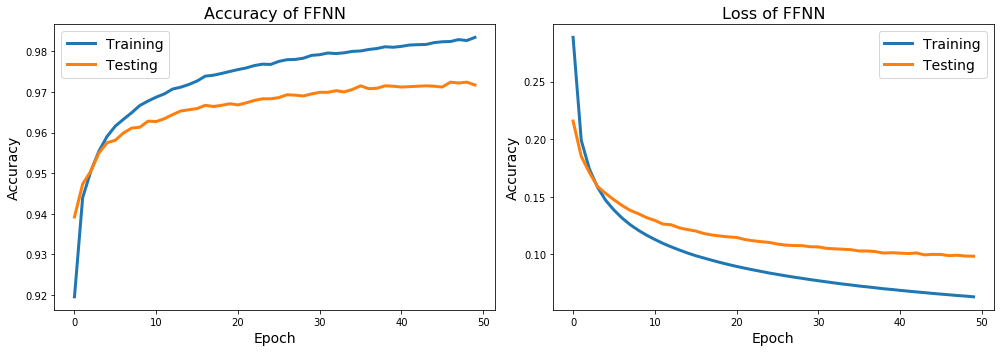

In [0]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history2.epoch, history2.history['accuracy'], lw=3, label='Training')
plt.plot(history2.epoch, history2.history['val_accuracy'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Accuracy of FFNN', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(history2.epoch, history2.history['loss'], lw=3, label='Training')
plt.plot(history2.epoch, history2.history['val_loss'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Loss of FFNN', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

plt.tight_layout()

Nous avons réalisé ici une validation croisée mais nous avons cherché les paramètres optimaux selon un procédé aléatoire. Le nombre de neurones présents dans la couche cachée est ici de 64, la taille du batch de 16 et le nombre d'époques de 50. Les résultats sont différents de la validation croisée précédente mais ils ne sont pas anormaux. Ce ne sont pas les paramètres optimaux car la première validation croisée a de meilleurs résultats mais ce sont les résultats optimaux vis à vis des combinaisons de paramètres qui ont été testé. Nous remarquons tout de même que le taux de prédiction réussi est toujours très bon et très proche de ce qu'on avait pu obtenir précédemment malgré le fait qu'il y ait moitié moins de paramètres (101770 précédemment et 50890 ici). 

**Question**

Run a cross-validation to analyze the influence of the the number of units of the hidden layer, the number of epochs and the batch-size.

### <font color=darkred> Convolutional Neural Networks </font>

In practice, increasing the size of hidden layers is not very effective. 
It is often a better idea to add more layers. 
Intuitively, if the observations have a hierarchical structure, adding more layers can be interpreted as a way to learn more levels of abstraction.  For example, in object detection tasks, it is easier to express shapes from edges and objects from shapes, than to express objects from pixels.  Thus, a good design should try to exploit this hierarchy.

In particular cases, such as grid-like data (time series, images), the observations can depend on a pattern which can be associated with different locations of the data. 
For example, an object can be in the middle or the left of the picture. 
Thus, the model has to be translation invariant: it is easier to learn how to recognize an object independently of its location. 

When two inputs might contain the same kind of information, then it is useful to share their weights and estimate the weights jointly for those inputs to learn statistical invariants (things that don't change much on average across time or space). 
Using this concept on images leads to convolutional neural networks (CNNs), on text, it results on recurrent neural networks (RNNs).  When using CNNs, weights are set to a small kernel that is used to perform a convolution across the image.

In the previous example, the step ``model_ffnn.add(Flatten(input_shape=input_shape))`` destroys the spatial organization of the input but is mandatory before the fully connected step: ``model_ffnn.add(Dense(128, activation='relu'))``. The spatial organization of the input may be preserved before using Flatten by convolution steps such as ``model_cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))``. This layer has 32 outputs, each of which depending on a 3*3 weight matrix.

Each output neuron of the next layer is computed as follows (image taken from https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-tensorflow/) before computing an elementwise RELU function:
<img src="conv.PNG">

The convolution maps patches of the input image, combined with the convolution kernel, for example
$$
\text{output} = \text{ReLU}(\text{patch} \times W + b)\,.
$$

Performing the convolution between the image and the weight matrix consists in moving the kernel across the image, and to produce an output for each patch. The way you move across the image is defined by two parameters:

- ``Stride``: the stride is the number of pixels you are shifting each time you move your kernel during the convolution.
- ``Padding``: defines what happens when the kernel reaches a border of the image when doing the convolution. 
"Valid" padding means that you stop at the edge, while "Same" padding allows to go off the edge and pad with zeros so that the width and the height of the output and input tensors are the same.

A classical approach is to use a stride of 1 and to combine theoutputs being in some neighborhood. Such an operation combining elements of a tensor is called ``pooling``: ``model_cnn.add(MaxPooling2D(pool_size=(2, 2)))``. Neighborhoods are define by the pooling window dimension (width x height) and the strides you use when moving this window across the image.  Again, a sliding window is applied along the input to produce the output, the most common function applied on each window being the ma function: it aggregates several outputs in a neighborhood $N$ using a max operation: 
$$
\text{output}'_i = \max_{j \in N}\text{output}_j, \quad i \in N.
$$
The formulas to compute the size of the ouput tensor are the same as for convolution padding and striding: (image taken from https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-tensorflow/):
<img src="maxpool.PNG">

In [0]:
model_cnn = Sequential()

model_cnn.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Conv2D(64, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25))
model_cnn.add(Flatten())
model_cnn.add(Dense(1024))   
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(num_classes, activation='softmax'))

model_cnn.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

model_cnn.summary()

Model: "sequential_123"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_122 (Flatten)        (None, 1024)              0         
_________________________________________________________________
dense_122 (Dense)            (None, 1024)           

In [0]:
batch_size = 32
epochs = 50

# Run the train
history = model_cnn.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test))
score = model_cnn.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 11s 188us/step - loss: 0.1201 - accuracy: 0.9628 - val_loss: 0.0361 - val_accuracy: 0.9878
Epoch 2/50
60000/60000 [==============================] - 8s 140us/step - loss: 0.0467 - accuracy: 0.9853 - val_loss: 0.0308 - val_accuracy: 0.9903
Epoch 3/50
60000/60000 [==============================] - 9s 151us/step - loss: 0.0368 - accuracy: 0.9885 - val_loss: 0.0248 - val_accuracy: 0.9925
Epoch 4/50
60000/60000 [==============================] - 9s 155us/step - loss: 0.0298 - accuracy: 0.9906 - val_loss: 0.0252 - val_accuracy: 0.9924
Epoch 5/50
60000/60000 [==============================] - 9s 157us/step - loss: 0.0272 - accuracy: 0.9917 - val_loss: 0.0206 - val_accuracy: 0.9938
Epoch 6/50
60000/60000 [==============================] - 9s 142us/step - loss: 0.0237 - accuracy: 0.9930 - val_loss: 0.0228 - val_accuracy: 0.9933
Epoch 7/50
60000/60000 [==============================] - 9s 

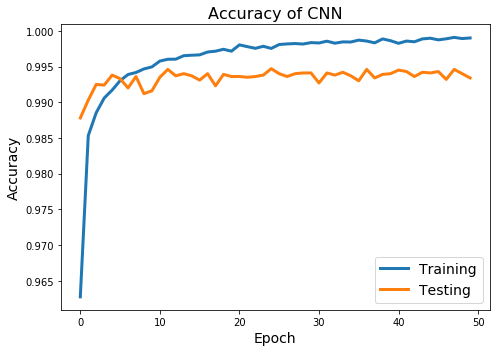

In [0]:
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['accuracy'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_accuracy'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Accuracy of CNN', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.tight_layout()

Nous utilisons ici un réseau de convolution. Nous obtenons des résultats très bon: un taux de prédictions réussies sur l'échantillon d'entrainement mais aussi sur l'échantillon de test qui est supérieur à 99%. Nous pouvons remarquer que le nombre de paramètres est environ multiplié par 10 par rapports à un FFNN avec 128 neuronnes dans sa couche cachée, obtenir de meilleurs résultats ne nous surprend donc pas. Nous pouvons par contre remarquer que la majorité des paramètres dépendent de la couche fully-connected.

In [0]:
def cnn_model(nb_neuron,kernel_size,actfunction):
    model_cnn = Sequential()

    model_cnn.add(Conv2D(32, kernel_size=(kernel_size, kernel_size), activation=actfunction, input_shape=input_shape))
    model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
    model_cnn.add(Conv2D(64, kernel_size=(kernel_size, kernel_size), activation=actfunction, input_shape=input_shape))
    model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
    model_cnn.add(Dropout(0.25))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(nb_neuron))   
    model_cnn.add(Dropout(0.5))
    model_cnn.add(Dense(num_classes, activation='softmax'))

    model_cnn.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
    
    return model_cnn


parameters = {'kernel_size':[3,5,7],
              'nb_neuron': [128,1024,2048],
              'actfunction': ['relu','softmax','sigmoid']}

keras_model = KerasRegressor(build_fn = cnn_model,epochs=50,batch_size=64,)

In [0]:
clf = GridSearchCV(keras_model, parameters, cv = 3)
clf.fit(x_train, y_train)
print(clf.best_params_)
best=clf.best_params_

Epoch 1/50
40000/40000 [==============================] - 3s 71us/step - loss: 0.2419 - accuracy: 0.9255
Epoch 2/50
40000/40000 [==============================] - 2s 59us/step - loss: 0.0860 - accuracy: 0.9730
Epoch 3/50
40000/40000 [==============================] - 3s 71us/step - loss: 0.0680 - accuracy: 0.9787
Epoch 4/50
40000/40000 [==============================] - 3s 67us/step - loss: 0.0549 - accuracy: 0.9825
Epoch 5/50
40000/40000 [==============================] - 3s 64us/step - loss: 0.0502 - accuracy: 0.9835
Epoch 6/50
40000/40000 [==============================] - 3s 71us/step - loss: 0.0429 - accuracy: 0.9865
Epoch 7/50
40000/40000 [==============================] - 3s 76us/step - loss: 0.0403 - accuracy: 0.9869
Epoch 8/50
40000/40000 [==============================] - 2s 61us/step - loss: 0.0342 - accuracy: 0.9890
Epoch 9/50
40000/40000 [==============================] - 3s 69us/step - loss: 0.0319 - accuracy: 0.9895
Epoch 10/50
40000/40000 [==============================

40000/40000 [==============================] - 3s 69us/step - loss: 0.0522 - accuracy: 0.9839
Epoch 4/50
40000/40000 [==============================] - 3s 69us/step - loss: 0.0455 - accuracy: 0.9852
Epoch 5/50
40000/40000 [==============================] - 3s 69us/step - loss: 0.0397 - accuracy: 0.9874
Epoch 6/50
40000/40000 [==============================] - 3s 70us/step - loss: 0.0362 - accuracy: 0.9885
Epoch 7/50
40000/40000 [==============================] - 3s 69us/step - loss: 0.0317 - accuracy: 0.9897
Epoch 8/50
40000/40000 [==============================] - 3s 70us/step - loss: 0.0283 - accuracy: 0.9908
Epoch 9/50
40000/40000 [==============================] - 3s 72us/step - loss: 0.0278 - accuracy: 0.9909
Epoch 10/50
40000/40000 [==============================] - 3s 69us/step - loss: 0.0245 - accuracy: 0.9918
Epoch 11/50
40000/40000 [==============================] - 3s 72us/step - loss: 0.0232 - accuracy: 0.9925
Epoch 12/50
40000/40000 [==============================] - 3s 72

40000/40000 [==============================] - 3s 81us/step - loss: 0.0407 - accuracy: 0.9873
Epoch 6/50
40000/40000 [==============================] - 3s 82us/step - loss: 0.0357 - accuracy: 0.9889
Epoch 7/50
40000/40000 [==============================] - 3s 82us/step - loss: 0.0337 - accuracy: 0.9896
Epoch 8/50
40000/40000 [==============================] - 3s 81us/step - loss: 0.0282 - accuracy: 0.9907
Epoch 9/50
40000/40000 [==============================] - 3s 82us/step - loss: 0.0265 - accuracy: 0.9918
Epoch 10/50
40000/40000 [==============================] - 3s 82us/step - loss: 0.0277 - accuracy: 0.9910
Epoch 11/50
40000/40000 [==============================] - 3s 82us/step - loss: 0.0243 - accuracy: 0.9916
Epoch 12/50
40000/40000 [==============================] - 3s 81us/step - loss: 0.0245 - accuracy: 0.9921
Epoch 13/50
40000/40000 [==============================] - 3s 81us/step - loss: 0.0253 - accuracy: 0.9919 
Epoch 14/50
40000/40000 [==============================] - 3s

Epoch 32/50
40000/40000 [==============================] - 3s 83us/step - loss: 0.0167 - accuracy: 0.9954
Epoch 33/50
40000/40000 [==============================] - 3s 83us/step - loss: 0.0169 - accuracy: 0.9955
Epoch 34/50
40000/40000 [==============================] - 3s 83us/step - loss: 0.0210 - accuracy: 0.9952
Epoch 35/50
40000/40000 [==============================] - 3s 83us/step - loss: 0.0167 - accuracy: 0.9955
Epoch 36/50
40000/40000 [==============================] - 3s 84us/step - loss: 0.0157 - accuracy: 0.9963
Epoch 37/50
40000/40000 [==============================] - 3s 83us/step - loss: 0.0175 - accuracy: 0.9957
Epoch 38/50
40000/40000 [==============================] - 3s 84us/step - loss: 0.0188 - accuracy: 0.9952
Epoch 39/50
40000/40000 [==============================] - 3s 82us/step - loss: 0.0210 - accuracy: 0.9951
Epoch 40/50
40000/40000 [==============================] - 3s 84us/step - loss: 0.0148 - accuracy: 0.9964
Epoch 41/50
40000/40000 [=====================

40000/40000 [==============================] - 3s 64us/step - loss: 0.0100 - accuracy: 0.9972 0s - loss: 0.0102 - accuracy: 0.
Epoch 35/50
40000/40000 [==============================] - 3s 65us/step - loss: 0.0077 - accuracy: 0.9974
Epoch 36/50
40000/40000 [==============================] - 3s 65us/step - loss: 0.0069 - accuracy: 0.9977
Epoch 37/50
40000/40000 [==============================] - 2s 60us/step - loss: 0.0102 - accuracy: 0.9973
Epoch 38/50
40000/40000 [==============================] - 3s 65us/step - loss: 0.0086 - accuracy: 0.9972
Epoch 39/50
40000/40000 [==============================] - 2s 60us/step - loss: 0.0082 - accuracy: 0.9974
Epoch 40/50
40000/40000 [==============================] - 3s 66us/step - loss: 0.0098 - accuracy: 0.9969
Epoch 41/50
40000/40000 [==============================] - 3s 66us/step - loss: 0.0079 - accuracy: 0.9979
Epoch 42/50
40000/40000 [==============================] - 3s 64us/step - loss: 0.0069 - accuracy: 0.9977
Epoch 43/50
40000/40000 [

40000/40000 [==============================] - 3s 75us/step - loss: 0.0143 - accuracy: 0.9965
Epoch 37/50
40000/40000 [==============================] - 3s 79us/step - loss: 0.0121 - accuracy: 0.9972
Epoch 38/50
40000/40000 [==============================] - 3s 70us/step - loss: 0.0131 - accuracy: 0.9967
Epoch 39/50
40000/40000 [==============================] - 3s 68us/step - loss: 0.0147 - accuracy: 0.9966
Epoch 40/50
40000/40000 [==============================] - 3s 67us/step - loss: 0.0157 - accuracy: 0.9967
Epoch 41/50
40000/40000 [==============================] - 3s 73us/step - loss: 0.0126 - accuracy: 0.9974
Epoch 42/50
40000/40000 [==============================] - 3s 67us/step - loss: 0.0158 - accuracy: 0.9963
Epoch 43/50
40000/40000 [==============================] - 3s 67us/step - loss: 0.0109 - accuracy: 0.9977
Epoch 44/50
40000/40000 [==============================] - 3s 70us/step - loss: 0.0181 - accuracy: 0.9965
Epoch 45/50
40000/40000 [==============================] -

40000/40000 [==============================] - 3s 78us/step - loss: 0.0128 - accuracy: 0.9973
Epoch 39/50
40000/40000 [==============================] - 3s 80us/step - loss: 0.0193 - accuracy: 0.9962
Epoch 40/50
40000/40000 [==============================] - 3s 76us/step - loss: 0.0232 - accuracy: 0.9962
Epoch 41/50
40000/40000 [==============================] - 3s 73us/step - loss: 0.0211 - accuracy: 0.9964
Epoch 42/50
40000/40000 [==============================] - 3s 74us/step - loss: 0.0252 - accuracy: 0.9959
Epoch 43/50
40000/40000 [==============================] - 3s 77us/step - loss: 0.0201 - accuracy: 0.9963
Epoch 44/50
40000/40000 [==============================] - 3s 73us/step - loss: 0.0168 - accuracy: 0.9967
Epoch 45/50
40000/40000 [==============================] - 3s 76us/step - loss: 0.0195 - accuracy: 0.9964
Epoch 46/50
40000/40000 [==============================] - 3s 87us/step - loss: 0.0199 - accuracy: 0.9965
Epoch 47/50
40000/40000 [==============================] -

40000/40000 [==============================] - 2s 60us/step - loss: 0.0211 - accuracy: 0.9935
Epoch 15/50
40000/40000 [==============================] - 3s 68us/step - loss: 0.0189 - accuracy: 0.9937
Epoch 16/50
40000/40000 [==============================] - 3s 64us/step - loss: 0.0171 - accuracy: 0.9945
Epoch 17/50
40000/40000 [==============================] - 2s 60us/step - loss: 0.0154 - accuracy: 0.9949
Epoch 18/50
40000/40000 [==============================] - 3s 66us/step - loss: 0.0159 - accuracy: 0.9956
Epoch 19/50
40000/40000 [==============================] - 2s 62us/step - loss: 0.0161 - accuracy: 0.9948
Epoch 20/50
40000/40000 [==============================] - 2s 61us/step - loss: 0.0171 - accuracy: 0.9948
Epoch 21/50
40000/40000 [==============================] - 2s 60us/step - loss: 0.0123 - accuracy: 0.9962
Epoch 22/50
40000/40000 [==============================] - 2s 60us/step - loss: 0.0152 - accuracy: 0.9953
Epoch 23/50
40000/40000 [==============================] -

40000/40000 [==============================] - 2s 61us/step - loss: 0.0198 - accuracy: 0.9942
Epoch 17/50
40000/40000 [==============================] - 2s 61us/step - loss: 0.0193 - accuracy: 0.9941
Epoch 18/50
40000/40000 [==============================] - 2s 61us/step - loss: 0.0200 - accuracy: 0.9936
Epoch 19/50
40000/40000 [==============================] - 3s 64us/step - loss: 0.0190 - accuracy: 0.9946
Epoch 20/50
40000/40000 [==============================] - 2s 62us/step - loss: 0.0196 - accuracy: 0.9944
Epoch 21/50
40000/40000 [==============================] - 2s 61us/step - loss: 0.0203 - accuracy: 0.9944
Epoch 22/50
40000/40000 [==============================] - 2s 62us/step - loss: 0.0167 - accuracy: 0.9951
Epoch 23/50
40000/40000 [==============================] - 2s 61us/step - loss: 0.0180 - accuracy: 0.9945
Epoch 24/50
40000/40000 [==============================] - 2s 62us/step - loss: 0.0156 - accuracy: 0.9954
Epoch 25/50
40000/40000 [==============================] -

40000/40000 [==============================] - 2s 62us/step - loss: 0.0245 - accuracy: 0.9934
Epoch 19/50
40000/40000 [==============================] - 2s 62us/step - loss: 0.0253 - accuracy: 0.9928
Epoch 20/50
40000/40000 [==============================] - 2s 62us/step - loss: 0.0270 - accuracy: 0.9928
Epoch 21/50
40000/40000 [==============================] - 2s 62us/step - loss: 0.0195 - accuracy: 0.9945
Epoch 22/50
40000/40000 [==============================] - 2s 62us/step - loss: 0.0230 - accuracy: 0.9935
Epoch 23/50
40000/40000 [==============================] - 2s 62us/step - loss: 0.0254 - accuracy: 0.9927
Epoch 24/50
40000/40000 [==============================] - 2s 61us/step - loss: 0.0248 - accuracy: 0.9938
Epoch 25/50
40000/40000 [==============================] - 2s 61us/step - loss: 0.0215 - accuracy: 0.9949
Epoch 26/50
40000/40000 [==============================] - 2s 61us/step - loss: 0.0175 - accuracy: 0.9955
Epoch 27/50
40000/40000 [==============================] -

40000/40000 [==============================] - 3s 78us/step - loss: 0.0480 - accuracy: 0.9852
Epoch 21/50
40000/40000 [==============================] - 3s 81us/step - loss: 0.0467 - accuracy: 0.9847
Epoch 22/50
40000/40000 [==============================] - 3s 76us/step - loss: 0.0457 - accuracy: 0.9857
Epoch 23/50
40000/40000 [==============================] - 3s 75us/step - loss: 0.0450 - accuracy: 0.9861
Epoch 24/50
40000/40000 [==============================] - 3s 80us/step - loss: 0.0435 - accuracy: 0.9861
Epoch 25/50
40000/40000 [==============================] - 3s 87us/step - loss: 0.0409 - accuracy: 0.9871
Epoch 26/50
40000/40000 [==============================] - 3s 79us/step - loss: 0.0422 - accuracy: 0.9866
Epoch 27/50
40000/40000 [==============================] - 3s 76us/step - loss: 0.0410 - accuracy: 0.9867
Epoch 28/50
40000/40000 [==============================] - 3s 79us/step - loss: 0.0401 - accuracy: 0.9874
Epoch 29/50
40000/40000 [==============================] -

40000/40000 [==============================] - 4s 89us/step - loss: 0.0509 - accuracy: 0.9848
Epoch 22/50
40000/40000 [==============================] - 4s 92us/step - loss: 0.0498 - accuracy: 0.9851
Epoch 23/50
40000/40000 [==============================] - 4s 94us/step - loss: 0.0495 - accuracy: 0.9851 0s - loss: 0.0496 - accuracy: 0.
Epoch 24/50
40000/40000 [==============================] - 4s 90us/step - loss: 0.0458 - accuracy: 0.9867
Epoch 25/50
40000/40000 [==============================] - 4s 89us/step - loss: 0.0508 - accuracy: 0.9855
Epoch 26/50
40000/40000 [==============================] - 4s 90us/step - loss: 0.0477 - accuracy: 0.9863
Epoch 27/50
40000/40000 [==============================] - 4s 92us/step - loss: 0.0433 - accuracy: 0.9872
Epoch 28/50
40000/40000 [==============================] - 4s 90us/step - loss: 0.0460 - accuracy: 0.9864
Epoch 29/50
40000/40000 [==============================] - 4s 90us/step - loss: 0.0425 - accuracy: 0.9879
Epoch 30/50
40000/40000 [

Epoch 23/50
40000/40000 [==============================] - 4s 102us/step - loss: 0.0588 - accuracy: 0.9848
Epoch 24/50
40000/40000 [==============================] - 4s 99us/step - loss: 0.0629 - accuracy: 0.9847
Epoch 25/50
40000/40000 [==============================] - 4s 100us/step - loss: 0.0590 - accuracy: 0.9852
Epoch 26/50
40000/40000 [==============================] - 4s 100us/step - loss: 0.0662 - accuracy: 0.9837
Epoch 27/50
40000/40000 [==============================] - 4s 100us/step - loss: 0.0599 - accuracy: 0.98541s
Epoch 28/50
40000/40000 [==============================] - 4s 101us/step - loss: 0.0620 - accuracy: 0.9852
Epoch 29/50
40000/40000 [==============================] - 4s 99us/step - loss: 0.0599 - accuracy: 0.9857
Epoch 30/50
40000/40000 [==============================] - 4s 100us/step - loss: 0.0608 - accuracy: 0.9856
Epoch 31/50
40000/40000 [==============================] - 4s 100us/step - loss: 0.0620 - accuracy: 0.9856
Epoch 32/50
40000/40000 [============

Epoch 25/50
40000/40000 [==============================] - 3s 77us/step - loss: 0.0199 - accuracy: 0.9936
Epoch 26/50
40000/40000 [==============================] - 3s 77us/step - loss: 0.0208 - accuracy: 0.9935
Epoch 27/50
40000/40000 [==============================] - 3s 83us/step - loss: 0.0177 - accuracy: 0.9941
Epoch 28/50
40000/40000 [==============================] - 3s 87us/step - loss: 0.0154 - accuracy: 0.9948
Epoch 29/50
40000/40000 [==============================] - 3s 78us/step - loss: 0.0166 - accuracy: 0.9943
Epoch 30/50
40000/40000 [==============================] - 3s 80us/step - loss: 0.0157 - accuracy: 0.9945
Epoch 31/50
40000/40000 [==============================] - 3s 83us/step - loss: 0.0149 - accuracy: 0.9953
Epoch 32/50
40000/40000 [==============================] - 3s 82us/step - loss: 0.0151 - accuracy: 0.9948
Epoch 33/50
40000/40000 [==============================] - 3s 80us/step - loss: 0.0128 - accuracy: 0.9958
Epoch 34/50
40000/40000 [=====================

40000/40000 [==============================] - 4s 88us/step - loss: 0.0205 - accuracy: 0.9944
Epoch 28/50
40000/40000 [==============================] - 4s 88us/step - loss: 0.0223 - accuracy: 0.9937
Epoch 29/50
40000/40000 [==============================] - 3s 87us/step - loss: 0.0231 - accuracy: 0.9938
Epoch 30/50
40000/40000 [==============================] - 4s 89us/step - loss: 0.0223 - accuracy: 0.9938
Epoch 31/50
40000/40000 [==============================] - 4s 89us/step - loss: 0.0216 - accuracy: 0.9946
Epoch 32/50
40000/40000 [==============================] - 3s 83us/step - loss: 0.0228 - accuracy: 0.9941
Epoch 33/50
40000/40000 [==============================] - 4s 90us/step - loss: 0.0225 - accuracy: 0.9945
Epoch 34/50
40000/40000 [==============================] - 4s 93us/step - loss: 0.0222 - accuracy: 0.9944
Epoch 35/50
40000/40000 [==============================] - 3s 80us/step - loss: 0.0201 - accuracy: 0.9948
Epoch 36/50
40000/40000 [==============================] -

40000/40000 [==============================] - 4s 89us/step - loss: 0.0347 - accuracy: 0.9930
Epoch 30/50
40000/40000 [==============================] - 4s 89us/step - loss: 0.0370 - accuracy: 0.9925
Epoch 31/50
40000/40000 [==============================] - 4s 89us/step - loss: 0.0304 - accuracy: 0.9930
Epoch 32/50
40000/40000 [==============================] - 4s 89us/step - loss: 0.0357 - accuracy: 0.9930
Epoch 33/50
40000/40000 [==============================] - 4s 89us/step - loss: 0.0326 - accuracy: 0.9932
Epoch 34/50
40000/40000 [==============================] - 4s 91us/step - loss: 0.0375 - accuracy: 0.9928
Epoch 35/50
40000/40000 [==============================] - 4s 89us/step - loss: 0.0348 - accuracy: 0.9932
Epoch 36/50
40000/40000 [==============================] - 4s 90us/step - loss: 0.0298 - accuracy: 0.9942
Epoch 37/50
40000/40000 [==============================] - 4s 89us/step - loss: 0.0391 - accuracy: 0.9934
Epoch 38/50
40000/40000 [==============================] -

40000/40000 [==============================] - 3s 72us/step - loss: 0.0165 - accuracy: 0.9948
Epoch 30/50
40000/40000 [==============================] - 3s 71us/step - loss: 0.0134 - accuracy: 0.9956
Epoch 31/50
40000/40000 [==============================] - 3s 74us/step - loss: 0.0126 - accuracy: 0.9956
Epoch 32/50
40000/40000 [==============================] - 3s 73us/step - loss: 0.0122 - accuracy: 0.9959
Epoch 33/50
40000/40000 [==============================] - 3s 74us/step - loss: 0.0121 - accuracy: 0.9955
Epoch 34/50
40000/40000 [==============================] - 3s 69us/step - loss: 0.0106 - accuracy: 0.9966
Epoch 35/50
40000/40000 [==============================] - 3s 74us/step - loss: 0.0120 - accuracy: 0.9962
Epoch 36/50
40000/40000 [==============================] - 3s 70us/step - loss: 0.0094 - accuracy: 0.9969
Epoch 37/50
40000/40000 [==============================] - 3s 76us/step - loss: 0.0116 - accuracy: 0.9963 1s - - ETA: 0s - loss: 0.0118 
Epoch 38/50
40000/40000 [==

40000/40000 [==============================] - 3s 81us/step - loss: 0.0805 - accuracy: 0.9765
Epoch 6/50
40000/40000 [==============================] - 3s 83us/step - loss: 0.0698 - accuracy: 0.9794
Epoch 7/50
40000/40000 [==============================] - 3s 83us/step - loss: 0.0603 - accuracy: 0.9814
Epoch 8/50
40000/40000 [==============================] - 3s 76us/step - loss: 0.0537 - accuracy: 0.9839
Epoch 9/50
40000/40000 [==============================] - 3s 75us/step - loss: 0.0488 - accuracy: 0.9851
Epoch 10/50
40000/40000 [==============================] - 3s 76us/step - loss: 0.0450 - accuracy: 0.9858
Epoch 11/50
40000/40000 [==============================] - 3s 81us/step - loss: 0.0405 - accuracy: 0.9873
Epoch 12/50
40000/40000 [==============================] - 3s 76us/step - loss: 0.0350 - accuracy: 0.9887
Epoch 13/50
40000/40000 [==============================] - 3s 80us/step - loss: 0.0343 - accuracy: 0.9892
Epoch 14/50
40000/40000 [==============================] - 3s 

Epoch 32/50
40000/40000 [==============================] - 3s 85us/step - loss: 0.0135 - accuracy: 0.9961
Epoch 33/50
40000/40000 [==============================] - 3s 78us/step - loss: 0.0131 - accuracy: 0.9959
Epoch 34/50
40000/40000 [==============================] - 4s 92us/step - loss: 0.0152 - accuracy: 0.9956
Epoch 35/50
40000/40000 [==============================] - 3s 85us/step - loss: 0.0127 - accuracy: 0.9964
Epoch 36/50
40000/40000 [==============================] - 4s 89us/step - loss: 0.0121 - accuracy: 0.9963
Epoch 37/50
40000/40000 [==============================] - 3s 80us/step - loss: 0.0143 - accuracy: 0.9959
Epoch 38/50
40000/40000 [==============================] - 3s 81us/step - loss: 0.0147 - accuracy: 0.9956
Epoch 39/50
40000/40000 [==============================] - 3s 83us/step - loss: 0.0134 - accuracy: 0.9965
Epoch 40/50
40000/40000 [==============================] - 3s 76us/step - loss: 0.0131 - accuracy: 0.9963
Epoch 41/50
40000/40000 [=====================

40000/40000 [==============================] - 3s 80us/step - loss: 0.0187 - accuracy: 0.9950
Epoch 35/50
40000/40000 [==============================] - 3s 74us/step - loss: 0.0173 - accuracy: 0.9956
Epoch 36/50
40000/40000 [==============================] - 3s 82us/step - loss: 0.0165 - accuracy: 0.9956
Epoch 37/50
40000/40000 [==============================] - 3s 74us/step - loss: 0.0152 - accuracy: 0.9956
Epoch 38/50
40000/40000 [==============================] - 3s 81us/step - loss: 0.0192 - accuracy: 0.9955
Epoch 39/50
40000/40000 [==============================] - 3s 79us/step - loss: 0.0184 - accuracy: 0.9954
Epoch 40/50
40000/40000 [==============================] - 3s 84us/step - loss: 0.0197 - accuracy: 0.9956
Epoch 41/50
40000/40000 [==============================] - 3s 77us/step - loss: 0.0220 - accuracy: 0.9948
Epoch 42/50
40000/40000 [==============================] - 3s 81us/step - loss: 0.0130 - accuracy: 0.9967
Epoch 43/50
40000/40000 [==============================] -

40000/40000 [==============================] - 3s 72us/step - loss: 0.0489 - accuracy: 0.9845
Epoch 36/50
40000/40000 [==============================] - 3s 73us/step - loss: 0.0455 - accuracy: 0.9854
Epoch 37/50
40000/40000 [==============================] - 3s 65us/step - loss: 0.0467 - accuracy: 0.9843
Epoch 38/50
40000/40000 [==============================] - 3s 69us/step - loss: 0.0424 - accuracy: 0.9863
Epoch 39/50
40000/40000 [==============================] - 3s 73us/step - loss: 0.0429 - accuracy: 0.9859
Epoch 40/50
40000/40000 [==============================] - 3s 66us/step - loss: 0.0407 - accuracy: 0.9873
Epoch 41/50
40000/40000 [==============================] - 3s 65us/step - loss: 0.0430 - accuracy: 0.9855
Epoch 42/50
40000/40000 [==============================] - 3s 66us/step - loss: 0.0392 - accuracy: 0.9877
Epoch 43/50
40000/40000 [==============================] - 3s 64us/step - loss: 0.0411 - accuracy: 0.9867
Epoch 44/50
40000/40000 [==============================] -

40000/40000 [==============================] - 3s 69us/step - loss: 0.0440 - accuracy: 0.9860
Epoch 38/50
40000/40000 [==============================] - 3s 70us/step - loss: 0.0452 - accuracy: 0.9846
Epoch 39/50
40000/40000 [==============================] - 3s 69us/step - loss: 0.0426 - accuracy: 0.9862
Epoch 40/50
40000/40000 [==============================] - 3s 69us/step - loss: 0.0441 - accuracy: 0.9857
Epoch 41/50
40000/40000 [==============================] - 3s 69us/step - loss: 0.0430 - accuracy: 0.9859
Epoch 42/50
40000/40000 [==============================] - 3s 72us/step - loss: 0.0385 - accuracy: 0.9868
Epoch 43/50
40000/40000 [==============================] - 3s 69us/step - loss: 0.0406 - accuracy: 0.9863
Epoch 44/50
40000/40000 [==============================] - 3s 82us/step - loss: 0.0392 - accuracy: 0.9870
Epoch 45/50
40000/40000 [==============================] - 3s 70us/step - loss: 0.0358 - accuracy: 0.9876
Epoch 46/50
40000/40000 [==============================] -

40000/40000 [==============================] - 3s 85us/step - loss: 0.0457 - accuracy: 0.9848
Epoch 40/50
40000/40000 [==============================] - 3s 84us/step - loss: 0.0476 - accuracy: 0.9842
Epoch 41/50
40000/40000 [==============================] - 3s 83us/step - loss: 0.0432 - accuracy: 0.9859
Epoch 42/50
40000/40000 [==============================] - 3s 85us/step - loss: 0.0443 - accuracy: 0.9850
Epoch 43/50
40000/40000 [==============================] - 3s 85us/step - loss: 0.0422 - accuracy: 0.9864
Epoch 44/50
40000/40000 [==============================] - 3s 84us/step - loss: 0.0415 - accuracy: 0.9859
Epoch 45/50
40000/40000 [==============================] - 3s 83us/step - loss: 0.0397 - accuracy: 0.9868
Epoch 46/50
40000/40000 [==============================] - 3s 83us/step - loss: 0.0404 - accuracy: 0.9865
Epoch 47/50
40000/40000 [==============================] - 3s 84us/step - loss: 0.0399 - accuracy: 0.9871 0s - loss: 0.0
Epoch 48/50
40000/40000 [==================

40000/40000 [==============================] - 3s 65us/step - loss: 0.0277 - accuracy: 0.9909
Epoch 41/50
40000/40000 [==============================] - 3s 65us/step - loss: 0.0257 - accuracy: 0.9917
Epoch 42/50
40000/40000 [==============================] - 3s 78us/step - loss: 0.0252 - accuracy: 0.9919
Epoch 43/50
40000/40000 [==============================] - 2s 62us/step - loss: 0.0228 - accuracy: 0.9928
Epoch 44/50
40000/40000 [==============================] - 2s 62us/step - loss: 0.0256 - accuracy: 0.9918
Epoch 45/50
40000/40000 [==============================] - 3s 63us/step - loss: 0.0226 - accuracy: 0.9923
Epoch 46/50
40000/40000 [==============================] - 2s 60us/step - loss: 0.0222 - accuracy: 0.9925
Epoch 47/50
40000/40000 [==============================] - 2s 60us/step - loss: 0.0208 - accuracy: 0.9934
Epoch 48/50
40000/40000 [==============================] - 3s 66us/step - loss: 0.0217 - accuracy: 0.9933
Epoch 49/50
40000/40000 [==============================] -

40000/40000 [==============================] - 3s 65us/step - loss: 0.0288 - accuracy: 0.9904
Epoch 43/50
40000/40000 [==============================] - 3s 69us/step - loss: 0.0259 - accuracy: 0.9916
Epoch 44/50
40000/40000 [==============================] - 3s 71us/step - loss: 0.0257 - accuracy: 0.9922
Epoch 45/50
40000/40000 [==============================] - 3s 69us/step - loss: 0.0238 - accuracy: 0.9925
Epoch 46/50
40000/40000 [==============================] - 3s 69us/step - loss: 0.0266 - accuracy: 0.9912
Epoch 47/50
40000/40000 [==============================] - 3s 68us/step - loss: 0.0234 - accuracy: 0.9923
Epoch 48/50
40000/40000 [==============================] - 3s 65us/step - loss: 0.0246 - accuracy: 0.9922
Epoch 49/50
40000/40000 [==============================] - 3s 68us/step - loss: 0.0232 - accuracy: 0.9924
Epoch 50/50
20000/20000 [==============================] - 1s 33us/step
Epoch 1/50
40000/40000 [==============================] - 3s 72us/step - loss: 1.9990 - accu

40000/40000 [==============================] - 3s 74us/step - loss: 0.0398 - accuracy: 0.9875
Epoch 45/50
40000/40000 [==============================] - 3s 76us/step - loss: 0.0358 - accuracy: 0.9883
Epoch 46/50
40000/40000 [==============================] - 3s 72us/step - loss: 0.0370 - accuracy: 0.9887
Epoch 47/50
40000/40000 [==============================] - 3s 75us/step - loss: 0.0401 - accuracy: 0.9880
Epoch 48/50
40000/40000 [==============================] - 3s 73us/step - loss: 0.0358 - accuracy: 0.9886
Epoch 49/50
40000/40000 [==============================] - 3s 74us/step - loss: 0.0314 - accuracy: 0.9897
Epoch 50/50
20000/20000 [==============================] - 1s 35us/step
Epoch 1/50
40000/40000 [==============================] - 3s 81us/step - loss: 2.0898 - accuracy: 0.2312
Epoch 2/50
40000/40000 [==============================] - 3s 73us/step - loss: 0.4552 - accuracy: 0.8543
Epoch 3/50
40000/40000 [==============================] - 3s 77us/step - loss: 0.2997 - accura

40000/40000 [==============================] - 2s 60us/step - loss: 0.0214 - accuracy: 0.9932
Epoch 47/50
40000/40000 [==============================] - 3s 63us/step - loss: 0.0205 - accuracy: 0.9936
Epoch 48/50
40000/40000 [==============================] - 3s 63us/step - loss: 0.0197 - accuracy: 0.9937
Epoch 49/50
40000/40000 [==============================] - 2s 60us/step - loss: 0.0196 - accuracy: 0.9933
Epoch 50/50
20000/20000 [==============================] - 1s 35us/step
Epoch 1/50
40000/40000 [==============================] - 3s 69us/step - loss: 1.3205 - accuracy: 0.5276
Epoch 2/50
40000/40000 [==============================] - 3s 66us/step - loss: 0.3272 - accuracy: 0.8992
Epoch 3/50
40000/40000 [==============================] - 3s 65us/step - loss: 0.2223 - accuracy: 0.9324
Epoch 4/50
40000/40000 [==============================] - 3s 66us/step - loss: 0.1739 - accuracy: 0.9479
Epoch 5/50
40000/40000 [==============================] - 3s 63us/step - loss: 0.1442 - accuracy

40000/40000 [==============================] - 2s 61us/step - loss: 0.0578 - accuracy: 0.9822
Epoch 49/50
40000/40000 [==============================] - 2s 59us/step - loss: 0.0526 - accuracy: 0.9839
Epoch 50/50
20000/20000 [==============================] - 1s 33us/step
Epoch 1/50
40000/40000 [==============================] - 3s 71us/step - loss: 1.5913 - accuracy: 0.4192
Epoch 2/50
40000/40000 [==============================] - 3s 63us/step - loss: 0.5707 - accuracy: 0.8104
Epoch 3/50
40000/40000 [==============================] - 3s 63us/step - loss: 0.3486 - accuracy: 0.8882
Epoch 4/50
40000/40000 [==============================] - 3s 63us/step - loss: 0.2652 - accuracy: 0.9163
Epoch 5/50
40000/40000 [==============================] - 3s 63us/step - loss: 0.2207 - accuracy: 0.9304
Epoch 6/50
40000/40000 [==============================] - 3s 63us/step - loss: 0.1928 - accuracy: 0.9399
Epoch 7/50
40000/40000 [==============================] - 3s 63us/step - loss: 0.1682 - accuracy: 

20000/20000 [==============================] - 1s 38us/step
Epoch 1/50
40000/40000 [==============================] - 3s 68us/step - loss: 1.4562 - accuracy: 0.4675
Epoch 2/50
40000/40000 [==============================] - 2s 61us/step - loss: 0.4884 - accuracy: 0.8446
Epoch 3/50
40000/40000 [==============================] - 2s 61us/step - loss: 0.3420 - accuracy: 0.8933
Epoch 4/50
40000/40000 [==============================] - 2s 60us/step - loss: 0.2793 - accuracy: 0.9145
Epoch 5/50
40000/40000 [==============================] - 2s 60us/step - loss: 0.2357 - accuracy: 0.9291
Epoch 6/50
40000/40000 [==============================] - 2s 60us/step - loss: 0.2046 - accuracy: 0.9390
Epoch 7/50
40000/40000 [==============================] - 2s 60us/step - loss: 0.1767 - accuracy: 0.9467
Epoch 8/50
40000/40000 [==============================] - 2s 60us/step - loss: 0.1643 - accuracy: 0.9493
Epoch 9/50
40000/40000 [==============================] - 2s 60us/step - loss: 0.1482 - accuracy: 0.

In [0]:
history=cnn_model(best['nb_neuron'],best['kernel_size'],best['actfunction']).fit(x_train, y_train,
                        batch_size=64,
                        epochs=50,
                        verbose=1,
                        validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 6s 102us/step - loss: 0.9615 - accuracy: 0.6604 - val_loss: 0.1489 - val_accuracy: 0.9552
Epoch 2/50
60000/60000 [==============================] - 5s 91us/step - loss: 0.1968 - accuracy: 0.9392 - val_loss: 0.0872 - val_accuracy: 0.9718
Epoch 3/50
60000/60000 [==============================] - 5s 87us/step - loss: 0.1493 - accuracy: 0.9544 - val_loss: 0.0748 - val_accuracy: 0.9759
Epoch 4/50
60000/60000 [==============================] - 5s 88us/step - loss: 0.1243 - accuracy: 0.9624 - val_loss: 0.0625 - val_accuracy: 0.9798
Epoch 5/50
60000/60000 [==============================] - 5s 88us/step - loss: 0.1082 - accuracy: 0.9673 - val_loss: 0.0537 - val_accuracy: 0.9828
Epoch 6/50
60000/60000 [==============================] - 5s 87us/step - loss: 0.0933 - accuracy: 0.9705 - val_loss: 0.0499 - val_accuracy: 0.9844
Epoch 7/50
60000/60000 [==============================] - 5s 85us/s

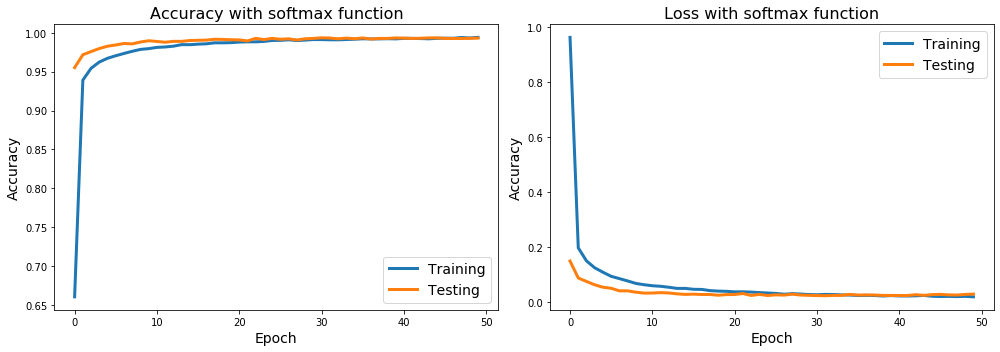

In [0]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, history.history['accuracy'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_accuracy'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Accuracy with ' + best['actfunction'] + ' function', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(history.epoch, history.history['loss'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_loss'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Loss with ' + best['actfunction'] + ' function', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

plt.tight_layout()

Nous réalisons une validation croisée  pour obtenir les paramètres optimaux. Les meilleurs résultats sont avec une fonction d'activation softmax, une kernel_size de 3 et 128 neurones dans la couche cachée. On obtient des taux de prédictions réussies à plus de 99%, que ce soit pour l'échantillon d'entraînement que celui de test.
Les résultats sur les données de test sont meilleurs d'environ 5% avec la validation croisée. C'est donc bien mieux car les résultats sur l'échantillon de test sont les plus représentatifs de la qualité du réseau de neurones car il témoigne de la capacité du réseau à prédire sur des données qu'il ne connait pas.
Avant la validation croisée nous avions comme paramètres une fonction d'activation relu, une kernel_size de 5 et 1024 neurones. C'est assez étonnant qu'on obtienne de meilleurs résultats avec moins de neurones (128) car nous avons ici bien moins de paramètres. Que la kernel_size soit plus petite peut être étonnant car cela signifie que nous prenons en compte l'environnement d'un pixel (les pixels autour, le contexte), mais un environnement très petit. Une taille de kernel de 3*3 montre que nous prenons en compte uniquement les pixels accolés à ce dernier. 

### <font color=darkred> notMNIST</font>

MNIST is a very very **clean** dataset. Digits are rescaled, smoothed, centered, and pixel values are normalized beforehand. Let's switch to a slightly harder dataset: [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html).

This time, labels are letters from 'A' to 'J' (10 classes). 
These letters are taken from digital fonts instead of handwriting pictures. 
We will use a reduced amount of data to ensure a reasonable training time. 
The training set you will use has 200K labelled examples, while the validation and test sets both contain 10K labelled examples.

In [0]:
import urllib

In [0]:
pickle_file = './notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    data = pkl.load(f)

In [0]:
data.keys()

dict_keys(['test_dataset', 'valid_labels', 'test_labels', 'train_dataset', 'train_labels', 'valid_dataset'])

In [0]:
def reshape(x, image_data_format, img_rows, img_cols):
    if image_data_format == 'channels_first':
        return x.astype(np.float32).reshape((-1, 1, img_rows, img_cols))
    else:
        return x.astype(np.float32).reshape((-1, img_rows, img_cols, 1))

img_rows, img_cols = 28, 28
num_labels = 10
image_data_format = K.image_data_format()

if image_data_format == 'channels_first':
    input_shape = (1, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, 1)
    
x_train = reshape(data['train_dataset'], image_data_format, img_rows, img_cols)
x_valid = reshape(data['valid_dataset'], image_data_format, img_rows, img_cols)
x_test = reshape(data['test_dataset'], image_data_format, img_rows, img_cols)

y_train = keras.utils.to_categorical(data['train_labels'])
y_valid = keras.utils.to_categorical(data['valid_labels'])
y_test = keras.utils.to_categorical(data['test_labels'])

print('x_train shape:', x_train.shape)
print('x_valid shape:', x_valid.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_valid shape:', y_valid.shape)
print('y_test shape:', y_test.shape)

print(x_train.shape[0], 'training samples')
print(x_valid.shape[0], 'validation samples')
print(x_test.shape[0], 'testing samples')

x_train shape: (200000, 28, 28, 1)
x_valid shape: (10000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
y_train shape: (200000, 10)
y_valid shape: (10000, 10)
y_test shape: (10000, 10)
200000 training samples
10000 validation samples
10000 testing samples


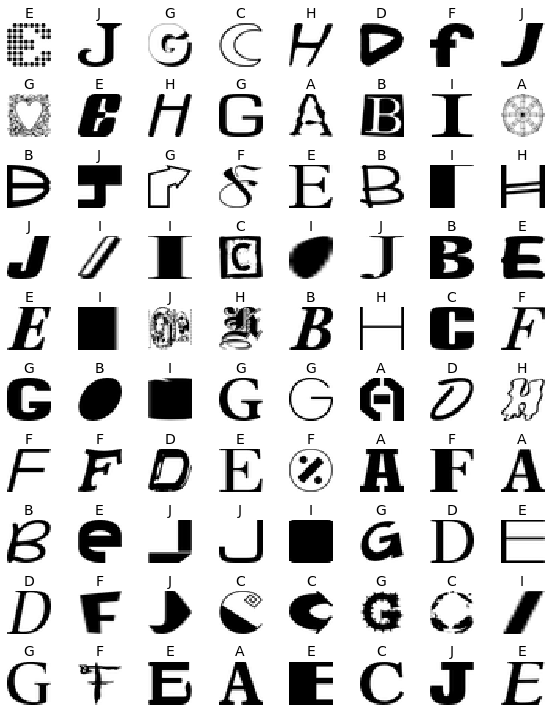

In [0]:
# plt.figure(figsize=(8, 4))
n_rows = 10
n_cols = 8
plt.figure(figsize=(n_cols, n_rows))

letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
def get_label(y):
    return letters[y.argmax()]

for i in range(n_rows * n_cols):
    ax = plt.subplot(n_rows, n_cols, i+1)
    ax.imshow(x_train[i].reshape(28, 28),
               interpolation="none", cmap="gray_r")
    ax.set_title(get_label(y_train[i]), fontsize=14)
    ax.axis("off")
plt.tight_layout()

**Question**

Train a softmax regression, visualize the weights, plot the convergence curves, save the model and its history (start with a small number of epochs, and increase the number of epochs).

In [0]:
model = Sequential()
# First we need to flatten the data: replace 28 * 28 matrices by flat vectors
# This is always necessary before feeding data to a fully-connected layer (Dense object)
model.add(Flatten(input_shape=input_shape, name='flatten'))

model.add(Dense(num_labels, activation='softmax', name='dense_softmax'))

model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adagrad(),
    metrics=['accuracy']
)
model.summary()

Model: "sequential_207"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_softmax (Dense)        (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [0]:
batch_size = 32
epochs = 50

# Run the train
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 200000 samples, validate on 10000 samples
Epoch 1/50
200000/200000 [==============================] - 17s 83us/step - loss: 0.6801 - accuracy: 0.8206 - val_loss: 0.4216 - val_accuracy: 0.8946
Epoch 2/50
200000/200000 [==============================] - 14s 71us/step - loss: 0.6506 - accuracy: 0.8282 - val_loss: 0.4134 - val_accuracy: 0.8969
Epoch 3/50
200000/200000 [==============================] - 14s 70us/step - loss: 0.6437 - accuracy: 0.8302 - val_loss: 0.4092 - val_accuracy: 0.8954
Epoch 4/50
200000/200000 [==============================] - 18s 89us/step - loss: 0.6397 - accuracy: 0.8313 - val_loss: 0.4076 - val_accuracy: 0.8973
Epoch 5/50
200000/200000 [==============================] - 13s 64us/step - loss: 0.6369 - accuracy: 0.8319 - val_loss: 0.4058 - val_accuracy: 0.8970
Epoch 6/50
200000/200000 [==============================] - 13s 64us/step - loss: 0.6349 - accuracy: 0.8325 - val_loss: 0.4047 - val_accuracy: 0.8966
Epoch 7/50
200000/200000 [=======================

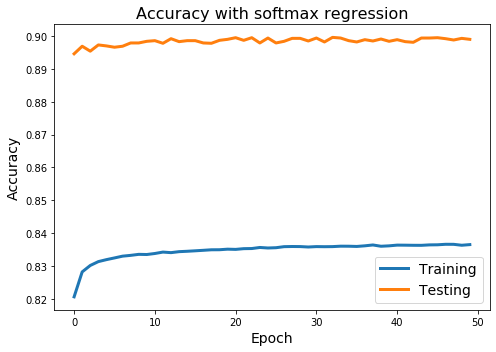

In [0]:
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['accuracy'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_accuracy'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Accuracy with softmax regression', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.tight_layout()

Résultats surprenants, peut-être dûs à la base de données. Nous obtenons un bien meilleur score sur l'échantillon de test (environ 6% de différence)...
Dans tous les cas, nous obtenons de moins bons résultats qu'avec la très bonne base de données de tout à l'heure. Le nombre d'éléments dans la base de données est bien plus grand que précédemment (200000 ici et 60000 précédemment), il faut donc peut être plus d'époques pour l'entrainer même si on peut en douter car le taux de prédictions réussies ne semble plus croitre. Il n'y a donc peut être tout simplement pas assez de paramètres dans le modèle.

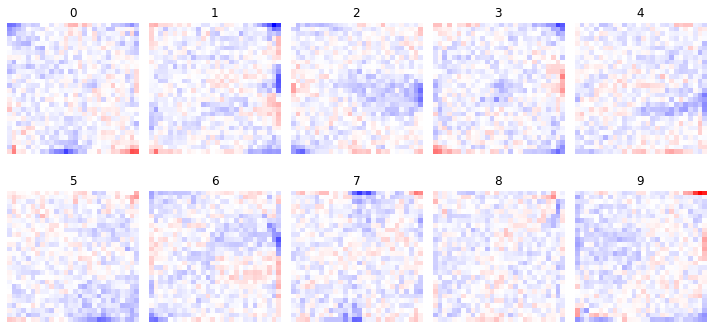

In [0]:
weights, biases = model.get_layer('dense_softmax').get_weights()
imgs = weights.reshape(28, 28, 10)

fig = plt.figure(figsize=(10, 5))
vmin, vmax = imgs.min(), imgs.max()
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    im = imgs[:, :, i]
    mappable = ax.imshow(im, interpolation="nearest", 
                         vmin=vmin, vmax=vmax, cmap='bwr')
    ax.axis('off')
    ax.set_title("%i" % i)
plt.tight_layout()

Contrairement à tout à l'heure, les lettres ne sont pas discernables sur les matrices des poids.

**Question**

Train FFNN with one hidden layer with 128 units, visualize the convergence curves, save the history.

In [0]:
model_ffnn = Sequential()

model_ffnn.add(Flatten(input_shape=input_shape))
model_ffnn.add(Dense(128, activation='relu', name='dense_Relu'))
model_ffnn.add(Dense(num_labels, activation='softmax'))

model_ffnn.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adagrad(),
    metrics=['accuracy']
)

model_ffnn.summary()

Model: "sequential_208"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_206 (Flatten)        (None, 784)               0         
_________________________________________________________________
dense_Relu (Dense)           (None, 128)               100480    
_________________________________________________________________
dense_290 (Dense)            (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [0]:
batch_size = 32
epochs = 50

# Run the train
history = model_ffnn.fit(x_train, y_train,
                         batch_size=batch_size,
                         epochs=epochs,
                         verbose=1,
                         validation_data=(x_test, y_test))
score = model_ffnn.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 200000 samples, validate on 10000 samples
Epoch 1/50
200000/200000 [==============================] - 18s 88us/step - loss: 0.5025 - accuracy: 0.8540 - val_loss: 0.2591 - val_accuracy: 0.9277
Epoch 2/50
200000/200000 [==============================] - 18s 90us/step - loss: 0.4277 - accuracy: 0.8755 - val_loss: 0.2374 - val_accuracy: 0.9354
Epoch 3/50
200000/200000 [==============================] - 16s 80us/step - loss: 0.4026 - accuracy: 0.8832 - val_loss: 0.2259 - val_accuracy: 0.9393
Epoch 4/50
200000/200000 [==============================] - 17s 84us/step - loss: 0.3865 - accuracy: 0.8883 - val_loss: 0.2181 - val_accuracy: 0.9402
Epoch 5/50
200000/200000 [==============================] - 17s 85us/step - loss: 0.3754 - accuracy: 0.8914 - val_loss: 0.2142 - val_accuracy: 0.9422
Epoch 6/50
200000/200000 [==============================] - 15s 77us/step - loss: 0.3664 - accuracy: 0.8939 - val_loss: 0.2099 - val_accuracy: 0.9430
Epoch 7/50
200000/200000 [=======================

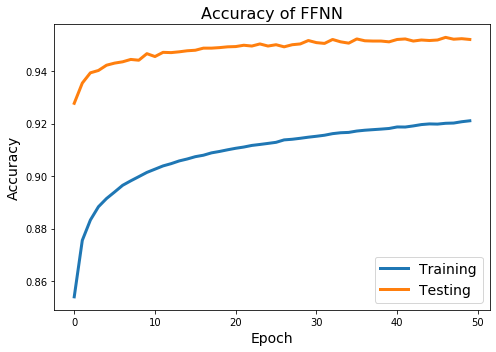

In [0]:
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['accuracy'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_accuracy'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Accuracy of FFNN', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.tight_layout()

De même, surprenant que nous obtenions de meilleurs résultats sur l'échantillon de test. Cependant, nous pouvons quand même remarquer que le taux de prédictions réussies continu de croitre sur l'echantillon d'entrainement. Il faut donc peut être un nombre plus grand d'époques.
De même, nous obtenons de moins bons résultats que tout à l'heure avec le FFNN et la base de données MNIST.

**Question**

Train a CNN with the following structure:

1. Convolutional layer with 32 filters and 5 * 5 kernel sizes and 'relu' activation
- Max pooling with pool size 2 * 2
- Convolutional layer with 64 filters and 5 * 5 kernel sizes and 'relu' activation
- Max pooling with pool size 2 * 2
- Dropout with probability 0.25
- Dense layer with 1024 units
- Dropout with probability 0.5
- Dense output layer with softmax activation

Use the Adam solver. Train for 20 epochs.

**Question**

Run a cross-validation to analyze the influence of the kernel sizes (step 1 and 3), the activation functions (step 1 and 3) and the number of units of the hidden layer (step 6).

In [0]:
def cnn_model(nb_neuron,kernel_size,actfunction):
    model_cnn = Sequential()

    model_cnn.add(Conv2D(32, kernel_size=(kernel_size, kernel_size), activation=actfunction, input_shape=input_shape))
    model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
    model_cnn.add(Conv2D(64, kernel_size=(kernel_size, kernel_size), activation=actfunction, input_shape=input_shape))
    model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
    model_cnn.add(Dropout(0.25))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(nb_neuron))   
    model_cnn.add(Dropout(0.5))
    model_cnn.add(Dense(num_labels, activation='softmax'))

    model_cnn.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
    
    return model_cnn


parameters = {'kernel_size':[3,5,7],
              'nb_neuron': [128,512,1024],
              'actfunction': ['relu','softmax','sigmoid']}


keras_model = KerasRegressor(build_fn = cnn_model,epochs=20,batch_size=512)

In [0]:
clf = GridSearchCV(keras_model, parameters, cv = 3)
clf.fit(x_train, y_train)
print(clf.best_params_)
best=clf.best_params_

Epoch 1/20
133333/133333 [==============================] - 4s 32us/step - loss: 0.7543 - accuracy: 0.7845
Epoch 2/20
133333/133333 [==============================] - 3s 19us/step - loss: 0.5245 - accuracy: 0.8536
Epoch 3/20
133333/133333 [==============================] - 3s 19us/step - loss: 0.4846 - accuracy: 0.8635
Epoch 4/20
133333/133333 [==============================] - 3s 19us/step - loss: 0.4614 - accuracy: 0.8697
Epoch 5/20
133333/133333 [==============================] - 3s 20us/step - loss: 0.4451 - accuracy: 0.8739
Epoch 6/20
133333/133333 [==============================] - 3s 20us/step - loss: 0.4322 - accuracy: 0.8773
Epoch 7/20
133333/133333 [==============================] - 3s 19us/step - loss: 0.4233 - accuracy: 0.8797
Epoch 8/20
133333/133333 [==============================] - 3s 20us/step - loss: 0.4158 - accuracy: 0.8819
Epoch 9/20
133333/133333 [==============================] - 3s 19us/step - loss: 0.4085 - accuracy: 0.8827
Epoch 10/20
133333/133333 [==========

133333/133333 [==============================] - 3s 22us/step - loss: 0.4062 - accuracy: 0.8842
Epoch 7/20
133333/133333 [==============================] - 3s 22us/step - loss: 0.3959 - accuracy: 0.8861
Epoch 8/20
133333/133333 [==============================] - 3s 22us/step - loss: 0.3905 - accuracy: 0.8876
Epoch 9/20
133333/133333 [==============================] - 3s 22us/step - loss: 0.3832 - accuracy: 0.8894
Epoch 10/20
133333/133333 [==============================] - 3s 22us/step - loss: 0.3788 - accuracy: 0.8904
Epoch 11/20
133333/133333 [==============================] - 3s 22us/step - loss: 0.3733 - accuracy: 0.8923
Epoch 12/20
133333/133333 [==============================] - 3s 22us/step - loss: 0.3700 - accuracy: 0.8931
Epoch 13/20
133333/133333 [==============================] - 3s 22us/step - loss: 0.3655 - accuracy: 0.8940
Epoch 14/20
133333/133333 [==============================] - 3s 22us/step - loss: 0.3615 - accuracy: 0.8951
Epoch 15/20
133333/133333 [================

133334/133334 [==============================] - 3s 19us/step - loss: 0.3174 - accuracy: 0.9059
Epoch 11/20
133334/133334 [==============================] - 3s 19us/step - loss: 0.3111 - accuracy: 0.9082A: 0s - loss: 0.3112 - accuracy: 0.90
Epoch 12/20
133334/133334 [==============================] - 3s 19us/step - loss: 0.3062 - accuracy: 0.9092
Epoch 13/20
133334/133334 [==============================] - 3s 19us/step - loss: 0.3014 - accuracy: 0.9104
Epoch 14/20
133334/133334 [==============================] - 3s 19us/step - loss: 0.2974 - accuracy: 0.9117
Epoch 15/20
133334/133334 [==============================] - 3s 19us/step - loss: 0.2932 - accuracy: 0.9132 0s -
Epoch 16/20
133334/133334 [==============================] - 3s 19us/step - loss: 0.2871 - accuracy: 0.9146
Epoch 17/20
133334/133334 [==============================] - 3s 19us/step - loss: 0.2832 - accuracy: 0.9163 0s - loss: 0.2835 - accuracy: 0.
Epoch 18/20
133334/133334 [==============================] - 3s 19us/step

133333/133333 [==============================] - 2s 17us/step - loss: 0.3394 - accuracy: 0.8955
Epoch 13/20
133333/133333 [==============================] - 2s 17us/step - loss: 0.3344 - accuracy: 0.8965
Epoch 14/20
133333/133333 [==============================] - 2s 17us/step - loss: 0.3273 - accuracy: 0.8976 0s - loss: 0.326
Epoch 15/20
133333/133333 [==============================] - 2s 17us/step - loss: 0.3197 - accuracy: 0.9000
Epoch 16/20
133333/133333 [==============================] - 2s 17us/step - loss: 0.3160 - accuracy: 0.9004
Epoch 17/20
133333/133333 [==============================] - 2s 17us/step - loss: 0.3091 - accuracy: 0.9037
Epoch 18/20
133333/133333 [==============================] - 2s 17us/step - loss: 0.3019 - accuracy: 0.9054 0s - loss: 0.3
Epoch 19/20
133333/133333 [==============================] - 2s 17us/step - loss: 0.2974 - accuracy: 0.9062
Epoch 20/20
66667/66667 [==============================] - 1s 10us/step
Epoch 1/20
133333/133333 [==================

133333/133333 [==============================] - 5s 35us/step - loss: 0.5211 - accuracy: 0.8547
Epoch 13/20
133333/133333 [==============================] - 5s 35us/step - loss: 0.5133 - accuracy: 0.8559
Epoch 14/20
133333/133333 [==============================] - 5s 35us/step - loss: 0.5015 - accuracy: 0.8584
Epoch 15/20
133333/133333 [==============================] - 5s 35us/step - loss: 0.4953 - accuracy: 0.8605
Epoch 16/20
133333/133333 [==============================] - 5s 35us/step - loss: 0.4875 - accuracy: 0.8618
Epoch 17/20
133333/133333 [==============================] - 5s 35us/step - loss: 0.4826 - accuracy: 0.8642 1s - loss: 0.4769 - accura
Epoch 18/20
133333/133333 [==============================] - 5s 35us/step - loss: 0.4754 - accuracy: 0.8657
Epoch 19/20
133333/133333 [==============================] - 5s 35us/step - loss: 0.4711 - accuracy: 0.8671
Epoch 20/20
66667/66667 [==============================] - 1s 13us/step
Epoch 1/20
133334/133334 [=======================

133334/133334 [==============================] - 5s 38us/step - loss: 0.4620 - accuracy: 0.8681
Epoch 18/20
133334/133334 [==============================] - 5s 38us/step - loss: 0.4578 - accuracy: 0.8692
Epoch 19/20
133334/133334 [==============================] - 5s 38us/step - loss: 0.4525 - accuracy: 0.8701
Epoch 20/20
66666/66666 [==============================] - 1s 13us/step
Epoch 1/20
133333/133333 [==============================] - 4s 33us/step - loss: 1.4704 - accuracy: 0.5091 1s
Epoch 2/20
133333/133333 [==============================] - 4s 31us/step - loss: 0.6680 - accuracy: 0.8125
Epoch 3/20
133333/133333 [==============================] - 4s 31us/step - loss: 0.5682 - accuracy: 0.8394
Epoch 4/20
133333/133333 [==============================] - 4s 31us/step - loss: 0.5215 - accuracy: 0.8521
Epoch 5/20
133333/133333 [==============================] - 4s 31us/step - loss: 0.4933 - accuracy: 0.8605
Epoch 6/20
133333/133333 [==============================] - 4s 31us/step - los

133333/133333 [==============================] - 5s 34us/step - loss: 1.3738 - accuracy: 0.5472
Epoch 2/20
133333/133333 [==============================] - 4s 32us/step - loss: 0.6413 - accuracy: 0.8198
Epoch 3/20
133333/133333 [==============================] - 4s 33us/step - loss: 0.5278 - accuracy: 0.8503
Epoch 4/20
133333/133333 [==============================] - 4s 32us/step - loss: 0.4834 - accuracy: 0.8628
Epoch 5/20
133333/133333 [==============================] - 4s 32us/step - loss: 0.4564 - accuracy: 0.8696
Epoch 6/20
133333/133333 [==============================] - 4s 32us/step - loss: 0.4344 - accuracy: 0.8755
Epoch 7/20
133333/133333 [==============================] - 4s 32us/step - loss: 0.4195 - accuracy: 0.8798
Epoch 8/20
133333/133333 [==============================] - 4s 33us/step - loss: 0.4073 - accuracy: 0.8822
Epoch 9/20
133333/133333 [==============================] - 4s 33us/step - loss: 0.3971 - accuracy: 0.8853
Epoch 10/20
133333/133333 [=====================

Epoch 15/20
133333/133333 [==============================] - 4s 27us/step - loss: 0.4288 - accuracy: 0.8694
Epoch 16/20
133333/133333 [==============================] - 4s 27us/step - loss: 0.4230 - accuracy: 0.8701
Epoch 17/20
133333/133333 [==============================] - 4s 26us/step - loss: 0.4160 - accuracy: 0.8723
Epoch 18/20
133333/133333 [==============================] - 4s 27us/step - loss: 0.4101 - accuracy: 0.8739
Epoch 19/20
133333/133333 [==============================] - 4s 27us/step - loss: 0.4052 - accuracy: 0.8760
Epoch 20/20
66667/66667 [==============================] - 1s 12us/step
Epoch 1/20
133334/133334 [==============================] - 4s 29us/step - loss: 1.5108 - accuracy: 0.4689
Epoch 2/20
133334/133334 [==============================] - 4s 27us/step - loss: 0.7333 - accuracy: 0.7738 0s - loss: 0.7352 - accuracy: 0.
Epoch 3/20
133334/133334 [==============================] - 4s 27us/step - loss: 0.6343 - accuracy: 0.8039
Epoch 4/20
133334/133334 [========

133334/133334 [==============================] - 4s 27us/step - loss: 0.3699 - accuracy: 0.8847
Epoch 20/20
66666/66666 [==============================] - 1s 11us/step
Epoch 1/20
133333/133333 [==============================] - 3s 22us/step - loss: 1.8460 - accuracy: 0.3714
Epoch 2/20
133333/133333 [==============================] - 3s 20us/step - loss: 0.9991 - accuracy: 0.7141
Epoch 3/20
133333/133333 [==============================] - 3s 20us/step - loss: 0.8162 - accuracy: 0.7661
Epoch 4/20
133333/133333 [==============================] - 3s 20us/step - loss: 0.7303 - accuracy: 0.7903
Epoch 5/20
133333/133333 [==============================] - 3s 20us/step - loss: 0.6839 - accuracy: 0.8046
Epoch 6/20
133333/133333 [==============================] - 3s 20us/step - loss: 0.6558 - accuracy: 0.8134
Epoch 7/20
133333/133333 [==============================] - 3s 20us/step - loss: 0.6331 - accuracy: 0.8199
Epoch 8/20
133333/133333 [==============================] - 3s 20us/step - loss: 0.

66667/66667 [==============================] - 1s 10us/step
Epoch 1/20
133333/133333 [==============================] - 3s 24us/step - loss: 2.1769 - accuracy: 0.3152
Epoch 2/20
133333/133333 [==============================] - 3s 22us/step - loss: 1.0442 - accuracy: 0.7010
Epoch 3/20
133333/133333 [==============================] - 3s 22us/step - loss: 0.8675 - accuracy: 0.7509
Epoch 4/20
133333/133333 [==============================] - 3s 22us/step - loss: 0.7830 - accuracy: 0.7721 0s - loss: 0.7848 - accuracy
Epoch 5/20
133333/133333 [==============================] - 3s 22us/step - loss: 0.7307 - accuracy: 0.7859
Epoch 6/20
133333/133333 [==============================] - 3s 22us/step - loss: 0.6968 - accuracy: 0.7968 0s - loss: 0.701 - ETA: 0s - loss: 0.6985 - ac
Epoch 7/20
133333/133333 [==============================] - 3s 22us/step - loss: 0.6735 - accuracy: 0.8025
Epoch 8/20
133333/133333 [==============================] - 3s 22us/step - loss: 0.6553 - accuracy: 0.8081
Epoch 9/

133334/133334 [==============================] - 3s 19us/step - loss: 0.7161 - accuracy: 0.8018
Epoch 4/20
133334/133334 [==============================] - 3s 20us/step - loss: 0.6580 - accuracy: 0.8150
Epoch 5/20
133334/133334 [==============================] - 3s 19us/step - loss: 0.6189 - accuracy: 0.8261
Epoch 6/20
133334/133334 [==============================] - 3s 20us/step - loss: 0.5923 - accuracy: 0.8325
Epoch 7/20
133334/133334 [==============================] - 3s 19us/step - loss: 0.5744 - accuracy: 0.8376
Epoch 8/20
133334/133334 [==============================] - 3s 19us/step - loss: 0.5549 - accuracy: 0.8422
Epoch 9/20
133334/133334 [==============================] - 3s 19us/step - loss: 0.5400 - accuracy: 0.8463 0s - loss: 0.543
Epoch 10/20
133334/133334 [==============================] - 3s 19us/step - loss: 0.5281 - accuracy: 0.8494
Epoch 11/20
133334/133334 [==============================] - 3s 19us/step - loss: 0.5121 - accuracy: 0.8536
Epoch 12/20
133334/133334 [==

133333/133333 [==============================] - 3s 21us/step - loss: 0.5835 - accuracy: 0.8239
Epoch 11/20
133333/133333 [==============================] - 3s 19us/step - loss: 0.5728 - accuracy: 0.8278
Epoch 12/20
133333/133333 [==============================] - 3s 19us/step - loss: 0.5649 - accuracy: 0.8292
Epoch 13/20
133333/133333 [==============================] - 3s 20us/step - loss: 0.5601 - accuracy: 0.8305
Epoch 14/20
133333/133333 [==============================] - 3s 19us/step - loss: 0.5494 - accuracy: 0.8339
Epoch 15/20
133333/133333 [==============================] - 3s 21us/step - loss: 0.5462 - accuracy: 0.8351
Epoch 16/20
133333/133333 [==============================] - 3s 19us/step - loss: 0.5378 - accuracy: 0.8372
Epoch 17/20
133333/133333 [==============================] - 2s 18us/step - loss: 0.5324 - accuracy: 0.8378
Epoch 18/20
133333/133333 [==============================] - 2s 18us/step - loss: 0.5261 - accuracy: 0.8393
Epoch 19/20
133333/133333 [=============

133333/133333 [==============================] - 3s 21us/step - loss: 0.7313 - accuracy: 0.7792
Epoch 5/20
133333/133333 [==============================] - 3s 20us/step - loss: 0.6767 - accuracy: 0.7963
Epoch 6/20
133333/133333 [==============================] - 4s 26us/step - loss: 0.6386 - accuracy: 0.8069
Epoch 7/20
133333/133333 [==============================] - 4s 34us/step - loss: 0.6121 - accuracy: 0.8152
Epoch 8/20
133333/133333 [==============================] - 4s 32us/step - loss: 0.5877 - accuracy: 0.8227
Epoch 9/20
133333/133333 [==============================] - 3s 22us/step - loss: 0.5720 - accuracy: 0.8264
Epoch 10/20
133333/133333 [==============================] - 3s 22us/step - loss: 0.5573 - accuracy: 0.8309
Epoch 11/20
133333/133333 [==============================] - 3s 21us/step - loss: 0.5456 - accuracy: 0.8352
Epoch 12/20
133333/133333 [==============================] - 3s 21us/step - loss: 0.5360 - accuracy: 0.8382
Epoch 13/20
133333/133333 [==================

In [0]:
history=cnn_model(best['nb_neuron'],best['kernel_size'],best['actfunction']).fit(x_train, y_train,
                        batch_size=64,
                        epochs=50,
                        verbose=1,
                        validation_data=(x_test, y_test))

Train on 200000 samples, validate on 10000 samples
Epoch 1/50
200000/200000 [==============================] - 25s 126us/step - loss: 0.4948 - accuracy: 0.8578 - val_loss: 0.1830 - val_accuracy: 0.9488
Epoch 2/50
200000/200000 [==============================] - 25s 124us/step - loss: 0.3954 - accuracy: 0.8864 - val_loss: 0.1672 - val_accuracy: 0.9528
Epoch 3/50
200000/200000 [==============================] - 24s 122us/step - loss: 0.3699 - accuracy: 0.8931 - val_loss: 0.1610 - val_accuracy: 0.9557
Epoch 4/50
200000/200000 [==============================] - 27s 133us/step - loss: 0.3525 - accuracy: 0.8974 - val_loss: 0.1519 - val_accuracy: 0.9570
Epoch 5/50
200000/200000 [==============================] - 25s 127us/step - loss: 0.3404 - accuracy: 0.9008 - val_loss: 0.1439 - val_accuracy: 0.9583
Epoch 6/50
200000/200000 [==============================] - 22s 112us/step - loss: 0.3316 - accuracy: 0.9038 - val_loss: 0.1401 - val_accuracy: 0.9609
Epoch 7/50
200000/200000 [=================

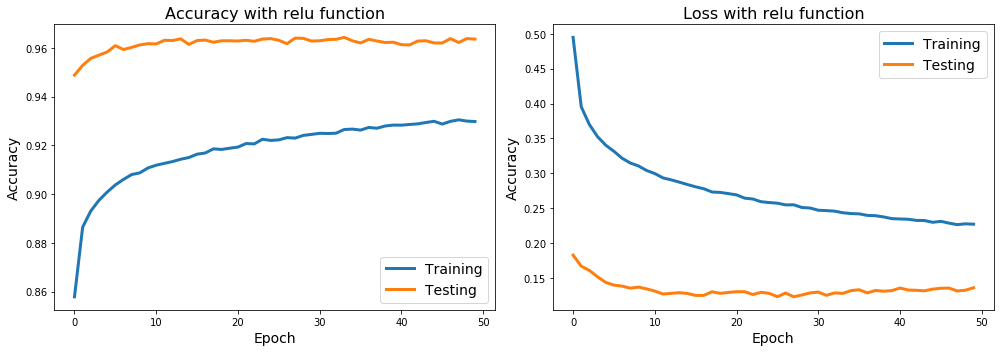

In [0]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, history.history['accuracy'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_accuracy'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Accuracy with ' + best['actfunction'] + ' function', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(history.epoch, history.history['loss'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_loss'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Loss with ' + best['actfunction'] + ' function', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

plt.tight_layout()

De même, surprenant que nous obtenions de meilleurs résultats sur l'échantillon de test. Comme précédemment, le taux de prédictions réussies croit encore sur l'échantillon d'entrainement.
De même, nous obtenons de moins bons résultats que tout à l'heure avec le CNN et la base de données MNIST. Nous remarquons que ici les paramètres optimaux ne sont pas les mêmes: relu comme fonction d'activation, 5*5 pour la taille du batch, et 128 neurones dans la couche fully-connected. Cela nous permet de voir que chaque problème à ses paramètres optimaux qui dépendent de la complexité des données et qu'un modèle ne peut pas être plaqué d'un problème à l'autre.

### <font color=darkred> Simple Recurrent neural networks</font>

In [0]:
from keras.layers.recurrent import SimpleRNN, LSTM
from keras.datasets import imdb
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.preprocessing import sequence

**IMDB sentiment classification task**

This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets.

IMDB provided a set of 25,000 highly popular movie reviews for training, and 25,000 for testing.

Dataset of 25,000 movies reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes (integers). For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words".

See here: https://keras.io/datasets/

In [0]:
# Top most frequent words to consider, other words are discarded
# Number of words considered as different features
max_features = 1000

# Maximum sequence length. Any longer sequence will be truncated.
maxlen = 50 

(x_train, y_train), (x_test, y_test) = imdb.load_data(nb_words = max_features)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)


# Build the sequences of maxlen words for each sample
x_train = sequence.pad_sequences(x_train, maxlen = maxlen)
x_test = sequence.pad_sequences(x_test, maxlen = maxlen)
print('X_train shape:', x_train.shape)
print('X_test shape:', x_test.shape)



C:\Users\axelc\Anaconda3\lib\site-packages\keras\datasets\imdb.py:49: UserWarning: The `nb_words` argument in `load_data` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `load_data` '


25000 train samples
25000 test samples
y_train shape: (25000,)
y_test shape: (25000,)
X_train shape: (25000, 50)
X_test shape: (25000, 50)


In [0]:
model_rnn = Sequential()

# Embedding layer, turns positive integers or indices into dense vectors of fixed size
model_rnn.add(Embedding(max_features, 32))
model_rnn.add(SimpleRNN(32))  
model_rnn.add(Dropout(0.5))
model_rnn.add(Dense(1, activation='sigmoid', name='dense_sigmoid'))

model_rnn.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

model_rnn.summary()

Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          32000     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dropout_167 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_sigmoid (Dense)        (None, 1)                 33        
Total params: 34,113
Trainable params: 34,113
Non-trainable params: 0
_________________________________________________________________


In [0]:
batch_size = 64
epochs = 50

history = model_rnn.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test))

C:\Users\axelc\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 25000 samples
Epoch 1/50
25000/25000 [==============================] - 9s 377us/step - loss: 0.6200 - accuracy: 0.6306 - val_loss: 0.4735 - val_accuracy: 0.7781
Epoch 2/50
25000/25000 [==============================] - 9s 365us/step - loss: 0.4702 - accuracy: 0.7839 - val_loss: 0.4557 - val_accuracy: 0.7868
Epoch 3/50
25000/25000 [==============================] - 9s 365us/step - loss: 0.4419 - accuracy: 0.8018 - val_loss: 0.4873 - val_accuracy: 0.7661
Epoch 4/50
25000/25000 [==============================] - 9s 365us/step - loss: 0.4110 - accuracy: 0.8174 - val_loss: 0.4810 - val_accuracy: 0.7812
Epoch 5/50
25000/25000 [==============================] - 9s 366us/step - loss: 0.3752 - accuracy: 0.8402 - val_loss: 0.5093 - val_accuracy: 0.7609
Epoch 6/50
25000/25000 [==============================] - 10s 382us/step - loss: 0.3441 - accuracy: 0.8552 - val_loss: 0.5599 - val_accuracy: 0.7446
Epoch 7/50
25000/25000 [==============================] - 10s

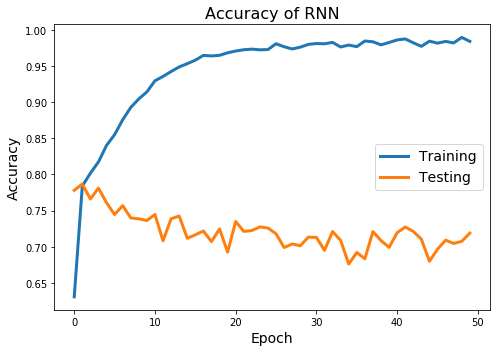

In [0]:
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['accuracy'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_accuracy'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Accuracy of RNN', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.tight_layout()

Nous observons ici clairement un surapprentissage. Sur l'échantillon d'entraînement le taux de réussite augmente, les prédictions sont très bien réussies, autour de 98%, alors que sur l'échantillon de test cela ne fait que décroître. Nous comprenons donc qu'il faut très peu d'étapes pour obtenir le meilleur taux de prédictions. Le RNN avec ces paramètres n'est pas adapté ici car sur l'échantillon de test cela décroit dès le début et le taux de prédictions réussies ne dépasse pas les 80%. Nous pouvons également nous dire que le problème étant plus complexe, avoir 80% de prédictions réussies n'est peut-être pas si mauvais. Nous pouvons aussi nous demander si les paramètres de notre réseau sont optimaux. Nous faisons donc une validation croisée.

**Question**

Run a cross-validation to analyze the influence of the size of the RNN layer and of the embedding layer.

In [0]:
def rnn_model(rnn_layer_size, embedd_layer_size):
    model_rnn = Sequential()

    model_rnn.add(Embedding(max_features, embedd_layer_size))
    model_rnn.add(SimpleRNN(rnn_layer_size))  
    model_rnn.add(Dropout(0.5))
    model_rnn.add(Dense(1, activation='sigmoid', name='dense_sigmoid'))

    model_rnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

    return model_rnn
    
parameters = {'rnn_layer_size':[16,32,64],
              'embedd_layer_size': [16,32,64],
              }

keras_model = KerasRegressor(build_fn = rnn_model,epochs=20,batch_size=64)

In [0]:
clf = GridSearchCV(keras_model, parameters, cv = 3)
clf.fit(x_train, y_train)
print(clf.best_params_)
best=clf.best_params_

C:\Users\axelc\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20
16666/16666 [==============================] - 5s 303us/step - loss: 0.6869 - accuracy: 0.5357
Epoch 2/20
16666/16666 [==============================] - 5s 293us/step - loss: 0.5443 - accuracy: 0.7432
Epoch 3/20
16666/16666 [==============================] - 5s 298us/step - loss: 0.4744 - accuracy: 0.7875
Epoch 4/20
16666/16666 [==============================] - 5s 302us/step - loss: 0.4349 - accuracy: 0.8123
Epoch 5/20
16666/16666 [==============================] - 5s 295us/step - loss: 0.4081 - accuracy: 0.8273
Epoch 6/20
16666/16666 [==============================] - 5s 299us/step - loss: 0.3798 - accuracy: 0.8406
Epoch 7/20
16666/16666 [==============================] - 5s 300us/step - loss: 0.3591 - accuracy: 0.85190s - loss: 0.3
Epoch 8/20
16666/16666 [==============================] - 5s 301us/step - loss: 0.3271 - accuracy: 0.8711
Epoch 9/20
16666/16666 [==============================] - 5s 298us/step - loss: 0.3138 - accuracy: 0.87590s - loss:
Epoch 10/20
16666/1666

C:\Users\axelc\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20
16667/16667 [==============================] - 5s 301us/step - loss: 0.5885 - accuracy: 0.6845
Epoch 2/20
16667/16667 [==============================] - 5s 284us/step - loss: 0.4809 - accuracy: 0.7820
Epoch 3/20
16667/16667 [==============================] - 5s 300us/step - loss: 0.4537 - accuracy: 0.8014
Epoch 4/20
16667/16667 [==============================] - 5s 300us/step - loss: 0.4344 - accuracy: 0.8079
Epoch 5/20
16667/16667 [==============================] - 5s 302us/step - loss: 0.4193 - accuracy: 0.8148
Epoch 6/20
16667/16667 [==============================] - 5s 289us/step - loss: 0.3992 - accuracy: 0.8283
Epoch 7/20
16667/16667 [==============================] - 5s 288us/step - loss: 0.3806 - accuracy: 0.8390
Epoch 8/20
16667/16667 [==============================] - 5s 292us/step - loss: 0.3561 - accuracy: 0.8511
Epoch 9/20
16667/16667 [==============================] - 5s 296us/step - loss: 0.3351 - accuracy: 0.8649
Epoch 10/20
16667/16667 [=====================

C:\Users\axelc\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20
16667/16667 [==============================] - 6s 331us/step - loss: 0.6749 - accuracy: 0.5626
Epoch 2/20
16667/16667 [==============================] - 5s 287us/step - loss: 0.5339 - accuracy: 0.7477
Epoch 3/20
16667/16667 [==============================] - 5s 294us/step - loss: 0.4763 - accuracy: 0.7863
Epoch 4/20
16667/16667 [==============================] - 5s 286us/step - loss: 0.4462 - accuracy: 0.8031
Epoch 5/20
16667/16667 [==============================] - 5s 288us/step - loss: 0.4220 - accuracy: 0.8201
Epoch 6/20
16667/16667 [==============================] - 5s 284us/step - loss: 0.4041 - accuracy: 0.8293
Epoch 7/20
16667/16667 [==============================] - 5s 287us/step - loss: 0.3810 - accuracy: 0.8391
Epoch 8/20
16667/16667 [==============================] - 5s 288us/step - loss: 0.3528 - accuracy: 0.8591
Epoch 9/20
16667/16667 [==============================] - 5s 286us/step - loss: 0.3274 - accuracy: 0.8707
Epoch 10/20
16667/16667 [=====================

C:\Users\axelc\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20
16666/16666 [==============================] - 5s 319us/step - loss: 0.6406 - accuracy: 0.6174
Epoch 2/20
16666/16666 [==============================] - 5s 311us/step - loss: 0.4804 - accuracy: 0.7764
Epoch 3/20
16666/16666 [==============================] - 5s 298us/step - loss: 0.4388 - accuracy: 0.8016
Epoch 4/20
16666/16666 [==============================] - 5s 298us/step - loss: 0.4094 - accuracy: 0.8217
Epoch 5/20
16666/16666 [==============================] - 5s 302us/step - loss: 0.3864 - accuracy: 0.8373
Epoch 6/20
16666/16666 [==============================] - 5s 306us/step - loss: 0.3612 - accuracy: 0.8476
Epoch 7/20
16666/16666 [==============================] - 5s 297us/step - loss: 0.3355 - accuracy: 0.8616
Epoch 8/20
16666/16666 [==============================] - 5s 294us/step - loss: 0.2993 - accuracy: 0.8814
Epoch 9/20
16666/16666 [==============================] - 5s 294us/step - loss: 0.2771 - accuracy: 0.8898
Epoch 10/20
16666/16666 [=====================

C:\Users\axelc\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20
16667/16667 [==============================] - 5s 312us/step - loss: 0.6525 - accuracy: 0.5887
Epoch 2/20
16667/16667 [==============================] - 5s 301us/step - loss: 0.4956 - accuracy: 0.7698
Epoch 3/20
16667/16667 [==============================] - 5s 312us/step - loss: 0.4527 - accuracy: 0.7958
Epoch 4/20
16667/16667 [==============================] - 5s 328us/step - loss: 0.4283 - accuracy: 0.80980s - loss: 0.4297 - accu
Epoch 5/20
16667/16667 [==============================] - 5s 304us/step - loss: 0.3979 - accuracy: 0.8289
Epoch 6/20
16667/16667 [==============================] - 5s 302us/step - loss: 0.3662 - accuracy: 0.8420
Epoch 7/20
16667/16667 [==============================] - 5s 299us/step - loss: 0.3283 - accuracy: 0.8635
Epoch 8/20
16667/16667 [==============================] - 5s 303us/step - loss: 0.3007 - accuracy: 0.87470s - loss: 0.2992 - accu
Epoch 9/20
16667/16667 [==============================] - 5s 298us/step - loss: 0.2670 - accuracy: 0.895

C:\Users\axelc\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20
16667/16667 [==============================] - 5s 302us/step - loss: 0.6459 - accuracy: 0.6076
Epoch 2/20
16667/16667 [==============================] - 5s 292us/step - loss: 0.4913 - accuracy: 0.7730
Epoch 3/20
16667/16667 [==============================] - 5s 292us/step - loss: 0.4511 - accuracy: 0.7978
Epoch 4/20
16667/16667 [==============================] - 5s 293us/step - loss: 0.4281 - accuracy: 0.8120
Epoch 5/20
16667/16667 [==============================] - 5s 297us/step - loss: 0.4049 - accuracy: 0.8217
Epoch 6/20
16667/16667 [==============================] - 5s 292us/step - loss: 0.3765 - accuracy: 0.8378
Epoch 7/20
16667/16667 [==============================] - 5s 295us/step - loss: 0.3480 - accuracy: 0.8553
Epoch 8/20
16667/16667 [==============================] - 5s 298us/step - loss: 0.3186 - accuracy: 0.8682
Epoch 9/20
16667/16667 [==============================] - 5s 298us/step - loss: 0.2883 - accuracy: 0.8864
Epoch 10/20
16667/16667 [=====================

C:\Users\axelc\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20
16666/16666 [==============================] - 5s 288us/step - loss: 0.6303 - accuracy: 0.6195
Epoch 2/20
16666/16666 [==============================] - 5s 280us/step - loss: 0.4841 - accuracy: 0.7738
Epoch 3/20
16666/16666 [==============================] - 5s 280us/step - loss: 0.4446 - accuracy: 0.7935
Epoch 4/20
16666/16666 [==============================] - 5s 280us/step - loss: 0.4266 - accuracy: 0.8108
Epoch 5/20
16666/16666 [==============================] - 5s 286us/step - loss: 0.4013 - accuracy: 0.8236
Epoch 6/20
16666/16666 [==============================] - 5s 293us/step - loss: 0.3644 - accuracy: 0.8432
Epoch 7/20
16666/16666 [==============================] - 5s 278us/step - loss: 0.3401 - accuracy: 0.8590
Epoch 8/20
16666/16666 [==============================] - 5s 286us/step - loss: 0.3013 - accuracy: 0.8782
Epoch 9/20
16666/16666 [==============================] - 5s 286us/step - loss: 0.2752 - accuracy: 0.8894
Epoch 10/20
16666/16666 [=====================

C:\Users\axelc\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20
16667/16667 [==============================] - 5s 307us/step - loss: 0.6793 - accuracy: 0.5594
Epoch 2/20
16667/16667 [==============================] - 5s 286us/step - loss: 0.5041 - accuracy: 0.7607
Epoch 3/20
16667/16667 [==============================] - 5s 286us/step - loss: 0.4488 - accuracy: 0.7933
Epoch 4/20
16667/16667 [==============================] - 5s 288us/step - loss: 0.4145 - accuracy: 0.8154
Epoch 5/20
16667/16667 [==============================] - 5s 283us/step - loss: 0.3861 - accuracy: 0.8315
Epoch 6/20
16667/16667 [==============================] - 5s 306us/step - loss: 0.3555 - accuracy: 0.8473
Epoch 7/20
16667/16667 [==============================] - 5s 296us/step - loss: 0.3259 - accuracy: 0.8622
Epoch 8/20
16667/16667 [==============================] - 5s 301us/step - loss: 0.2962 - accuracy: 0.8760
Epoch 9/20
16667/16667 [==============================] - 5s 302us/step - loss: 0.2695 - accuracy: 0.8896
Epoch 10/20
16667/16667 [=====================

C:\Users\axelc\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20
16667/16667 [==============================] - 5s 295us/step - loss: 0.6710 - accuracy: 0.5702
Epoch 2/20
16667/16667 [==============================] - 5s 282us/step - loss: 0.4970 - accuracy: 0.7676
Epoch 3/20
16667/16667 [==============================] - 5s 289us/step - loss: 0.4563 - accuracy: 0.7919
Epoch 4/20
16667/16667 [==============================] - 5s 288us/step - loss: 0.4257 - accuracy: 0.8055
Epoch 5/20
16667/16667 [==============================] - 5s 292us/step - loss: 0.4027 - accuracy: 0.8199
Epoch 6/20
16667/16667 [==============================] - 5s 286us/step - loss: 0.3688 - accuracy: 0.8409
Epoch 7/20
16667/16667 [==============================] - 5s 285us/step - loss: 0.3374 - accuracy: 0.8558
Epoch 8/20
16667/16667 [==============================] - 5s 282us/step - loss: 0.3011 - accuracy: 0.8751
Epoch 9/20
16667/16667 [==============================] - 5s 291us/step - loss: 0.2752 - accuracy: 0.8871
Epoch 10/20
16667/16667 [=====================

C:\Users\axelc\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20
16666/16666 [==============================] - 5s 296us/step - loss: 0.6697 - accuracy: 0.5646
Epoch 2/20
16666/16666 [==============================] - 5s 290us/step - loss: 0.5038 - accuracy: 0.7685
Epoch 3/20
16666/16666 [==============================] - 5s 290us/step - loss: 0.4601 - accuracy: 0.7942
Epoch 4/20
16666/16666 [==============================] - 5s 290us/step - loss: 0.4259 - accuracy: 0.8139
Epoch 5/20
16666/16666 [==============================] - 5s 292us/step - loss: 0.4015 - accuracy: 0.8294
Epoch 6/20
16666/16666 [==============================] - 5s 287us/step - loss: 0.3717 - accuracy: 0.8481
Epoch 7/20
16666/16666 [==============================] - 5s 289us/step - loss: 0.3496 - accuracy: 0.8570
Epoch 8/20
16666/16666 [==============================] - 5s 286us/step - loss: 0.3139 - accuracy: 0.8762
Epoch 9/20
16666/16666 [==============================] - 5s 286us/step - loss: 0.2934 - accuracy: 0.8862
Epoch 10/20
16666/16666 [=====================

C:\Users\axelc\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20
16667/16667 [==============================] - 5s 299us/step - loss: 0.6066 - accuracy: 0.6648
Epoch 2/20
16667/16667 [==============================] - 5s 292us/step - loss: 0.4881 - accuracy: 0.7815
Epoch 3/20
16667/16667 [==============================] - 5s 292us/step - loss: 0.4641 - accuracy: 0.7925
Epoch 4/20
16667/16667 [==============================] - 5s 293us/step - loss: 0.4378 - accuracy: 0.8126
Epoch 5/20
16667/16667 [==============================] - 5s 293us/step - loss: 0.4142 - accuracy: 0.8240
Epoch 6/20
16667/16667 [==============================] - 5s 294us/step - loss: 0.3959 - accuracy: 0.8318
Epoch 7/20
16667/16667 [==============================] - 5s 291us/step - loss: 0.3692 - accuracy: 0.8486
Epoch 8/20
16667/16667 [==============================] - 6s 333us/step - loss: 0.3397 - accuracy: 0.8652
Epoch 9/20
16667/16667 [==============================] - 5s 312us/step - loss: 0.3206 - accuracy: 0.8727
Epoch 10/20
16667/16667 [=====================

C:\Users\axelc\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20
16667/16667 [==============================] - 5s 313us/step - loss: 0.6477 - accuracy: 0.6057
Epoch 2/20
16667/16667 [==============================] - 5s 311us/step - loss: 0.5095 - accuracy: 0.7631
Epoch 3/20
16667/16667 [==============================] - 5s 326us/step - loss: 0.4656 - accuracy: 0.7930
Epoch 4/20
16667/16667 [==============================] - 5s 299us/step - loss: 0.4386 - accuracy: 0.8103
Epoch 5/20
16667/16667 [==============================] - 5s 296us/step - loss: 0.4122 - accuracy: 0.8237
Epoch 6/20
16667/16667 [==============================] - 5s 298us/step - loss: 0.3927 - accuracy: 0.83240s - loss: 0.3890 - accura
Epoch 7/20
16667/16667 [==============================] - 5s 301us/step - loss: 0.3670 - accuracy: 0.8481
Epoch 8/20
16667/16667 [==============================] - 5s 300us/step - loss: 0.3391 - accuracy: 0.8624
Epoch 9/20
16667/16667 [==============================] - 5s 301us/step - loss: 0.3178 - accuracy: 0.8723
Epoch 10/20
16667/16

C:\Users\axelc\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20
16666/16666 [==============================] - 5s 311us/step - loss: 0.6769 - accuracy: 0.5616
Epoch 2/20
16666/16666 [==============================] - 5s 298us/step - loss: 0.5107 - accuracy: 0.7550
Epoch 3/20
16666/16666 [==============================] - 5s 305us/step - loss: 0.4452 - accuracy: 0.8008
Epoch 4/20
16666/16666 [==============================] - 5s 304us/step - loss: 0.3992 - accuracy: 0.8235
Epoch 5/20
16666/16666 [==============================] - 5s 307us/step - loss: 0.3459 - accuracy: 0.8555
Epoch 6/20
16666/16666 [==============================] - 5s 304us/step - loss: 0.2947 - accuracy: 0.8824
Epoch 7/20
16666/16666 [==============================] - 5s 303us/step - loss: 0.2467 - accuracy: 0.9047
Epoch 8/20
16666/16666 [==============================] - 5s 301us/step - loss: 0.2062 - accuracy: 0.9233
Epoch 9/20
16666/16666 [==============================] - 5s 300us/step - loss: 0.1653 - accuracy: 0.9420
Epoch 10/20
16666/16666 [=====================

C:\Users\axelc\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20
16667/16667 [==============================] - 6s 345us/step - loss: 0.6531 - accuracy: 0.5922
Epoch 2/20
16667/16667 [==============================] - 5s 305us/step - loss: 0.4892 - accuracy: 0.7703
Epoch 3/20
16667/16667 [==============================] - 5s 307us/step - loss: 0.4468 - accuracy: 0.80080s - loss: 0.4483 - accura
Epoch 4/20
16667/16667 [==============================] - 5s 307us/step - loss: 0.4096 - accuracy: 0.8220
Epoch 5/20
16667/16667 [==============================] - 5s 301us/step - loss: 0.3682 - accuracy: 0.8467
Epoch 6/20
16667/16667 [==============================] - 5s 304us/step - loss: 0.3277 - accuracy: 0.8645
Epoch 7/20
16667/16667 [==============================] - 5s 300us/step - loss: 0.2848 - accuracy: 0.88400s - loss: 0.2805 
Epoch 8/20
16667/16667 [==============================] - 5s 309us/step - loss: 0.2424 - accuracy: 0.9055
Epoch 9/20
16667/16667 [==============================] - 5s 306us/step - loss: 0.1986 - accuracy: 0.9236
Ep

C:\Users\axelc\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20
16667/16667 [==============================] - 5s 307us/step - loss: 0.6260 - accuracy: 0.6289
Epoch 2/20
16667/16667 [==============================] - 5s 292us/step - loss: 0.4812 - accuracy: 0.7778
Epoch 3/20
16667/16667 [==============================] - 5s 295us/step - loss: 0.4464 - accuracy: 0.7983
Epoch 4/20
16667/16667 [==============================] - 5s 295us/step - loss: 0.4122 - accuracy: 0.8201
Epoch 5/20
16667/16667 [==============================] - 5s 293us/step - loss: 0.3743 - accuracy: 0.8393
Epoch 6/20
16667/16667 [==============================] - 5s 295us/step - loss: 0.3315 - accuracy: 0.8646
Epoch 7/20
16667/16667 [==============================] - 5s 290us/step - loss: 0.2812 - accuracy: 0.8893
Epoch 8/20
16667/16667 [==============================] - 5s 295us/step - loss: 0.2466 - accuracy: 0.9044
Epoch 9/20
16667/16667 [==============================] - 5s 296us/step - loss: 0.2014 - accuracy: 0.9258
Epoch 10/20
16667/16667 [=====================

C:\Users\axelc\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20
16666/16666 [==============================] - 5s 301us/step - loss: 0.6857 - accuracy: 0.5392
Epoch 2/20
16666/16666 [==============================] - 5s 282us/step - loss: 0.5142 - accuracy: 0.7526
Epoch 3/20
16666/16666 [==============================] - 5s 278us/step - loss: 0.4511 - accuracy: 0.7929
Epoch 4/20
16666/16666 [==============================] - 5s 294us/step - loss: 0.3957 - accuracy: 0.8260
Epoch 5/20
16666/16666 [==============================] - 5s 287us/step - loss: 0.3559 - accuracy: 0.8485
Epoch 6/20
16666/16666 [==============================] - 5s 289us/step - loss: 0.2965 - accuracy: 0.8793
Epoch 7/20
16666/16666 [==============================] - 5s 290us/step - loss: 0.2453 - accuracy: 0.9047
Epoch 8/20
16666/16666 [==============================] - 5s 277us/step - loss: 0.2001 - accuracy: 0.9215
Epoch 9/20
16666/16666 [==============================] - 5s 282us/step - loss: 0.1756 - accuracy: 0.9333
Epoch 10/20
16666/16666 [=====================

C:\Users\axelc\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20
16667/16667 [==============================] - 5s 300us/step - loss: 0.6389 - accuracy: 0.6127
Epoch 2/20
16667/16667 [==============================] - 5s 283us/step - loss: 0.4885 - accuracy: 0.7670
Epoch 3/20
16667/16667 [==============================] - 5s 285us/step - loss: 0.4439 - accuracy: 0.7988
Epoch 4/20
16667/16667 [==============================] - 5s 282us/step - loss: 0.4094 - accuracy: 0.8198
Epoch 5/20
16667/16667 [==============================] - 5s 284us/step - loss: 0.3602 - accuracy: 0.8457
Epoch 6/20
16667/16667 [==============================] - 5s 285us/step - loss: 0.3128 - accuracy: 0.8703
Epoch 7/20
16667/16667 [==============================] - 5s 282us/step - loss: 0.2617 - accuracy: 0.8964
Epoch 8/20
16667/16667 [==============================] - 5s 288us/step - loss: 0.2191 - accuracy: 0.9132
Epoch 9/20
16667/16667 [==============================] - 5s 284us/step - loss: 0.1781 - accuracy: 0.9312
Epoch 10/20
16667/16667 [=====================

C:\Users\axelc\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20
16667/16667 [==============================] - 5s 297us/step - loss: 0.6693 - accuracy: 0.5622
Epoch 2/20
16667/16667 [==============================] - 5s 284us/step - loss: 0.5025 - accuracy: 0.7662
Epoch 3/20
16667/16667 [==============================] - 5s 287us/step - loss: 0.4478 - accuracy: 0.7961
Epoch 4/20
16667/16667 [==============================] - 5s 287us/step - loss: 0.4122 - accuracy: 0.8165
Epoch 5/20
16667/16667 [==============================] - 5s 282us/step - loss: 0.3649 - accuracy: 0.8468
Epoch 6/20
16667/16667 [==============================] - 5s 291us/step - loss: 0.3171 - accuracy: 0.8697
Epoch 7/20
16667/16667 [==============================] - 5s 289us/step - loss: 0.2701 - accuracy: 0.8884
Epoch 8/20
16667/16667 [==============================] - 5s 287us/step - loss: 0.2287 - accuracy: 0.9074
Epoch 9/20
16667/16667 [==============================] - 5s 292us/step - loss: 0.1844 - accuracy: 0.9294
Epoch 10/20
16667/16667 [=====================

C:\Users\axelc\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20
16666/16666 [==============================] - 5s 297us/step - loss: 0.6082 - accuracy: 0.6676
Epoch 2/20
16666/16666 [==============================] - 5s 277us/step - loss: 0.4894 - accuracy: 0.7809
Epoch 3/20
16666/16666 [==============================] - 5s 283us/step - loss: 0.4482 - accuracy: 0.8007
Epoch 4/20
16666/16666 [==============================] - 5s 280us/step - loss: 0.4115 - accuracy: 0.8244
Epoch 5/20
16666/16666 [==============================] - 5s 290us/step - loss: 0.3753 - accuracy: 0.8409
Epoch 6/20
16666/16666 [==============================] - 5s 286us/step - loss: 0.3326 - accuracy: 0.8647
Epoch 7/20
16666/16666 [==============================] - 5s 285us/step - loss: 0.3033 - accuracy: 0.8789
Epoch 8/20
16666/16666 [==============================] - 5s 284us/step - loss: 0.2736 - accuracy: 0.8915
Epoch 9/20
16666/16666 [==============================] - 5s 285us/step - loss: 0.2509 - accuracy: 0.9049
Epoch 10/20
16666/16666 [=====================

C:\Users\axelc\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20
16667/16667 [==============================] - 5s 294us/step - loss: 0.6274 - accuracy: 0.6329
Epoch 2/20
16667/16667 [==============================] - 5s 277us/step - loss: 0.4851 - accuracy: 0.7788
Epoch 3/20
16667/16667 [==============================] - 5s 284us/step - loss: 0.4490 - accuracy: 0.8016
Epoch 4/20
16667/16667 [==============================] - 5s 290us/step - loss: 0.4117 - accuracy: 0.82220s - loss: 0.4 - ETA: 0s - loss: 0.4116 - accuracy: 0.82
Epoch 5/20
16667/16667 [==============================] - 5s 296us/step - loss: 0.3840 - accuracy: 0.8384
Epoch 6/20
16667/16667 [==============================] - 5s 289us/step - loss: 0.3527 - accuracy: 0.8544
Epoch 7/20
16667/16667 [==============================] - 5s 287us/step - loss: 0.3204 - accuracy: 0.8704
Epoch 8/20
16667/16667 [==============================] - 5s 287us/step - loss: 0.2945 - accuracy: 0.8844
Epoch 9/20
16667/16667 [==============================] - 5s 291us/step - loss: 0.2734 - accurac

C:\Users\axelc\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20
16667/16667 [==============================] - 5s 308us/step - loss: 0.6871 - accuracy: 0.5384
Epoch 2/20
16667/16667 [==============================] - 5s 290us/step - loss: 0.5490 - accuracy: 0.7298
Epoch 3/20
16667/16667 [==============================] - 5s 288us/step - loss: 0.4636 - accuracy: 0.7932
Epoch 4/20
16667/16667 [==============================] - 5s 288us/step - loss: 0.4170 - accuracy: 0.8209
Epoch 5/20
16667/16667 [==============================] - 5s 291us/step - loss: 0.3726 - accuracy: 0.8462
Epoch 6/20
16667/16667 [==============================] - 5s 286us/step - loss: 0.3422 - accuracy: 0.86190s - loss: 0
Epoch 7/20
16667/16667 [==============================] - 5s 286us/step - loss: 0.3078 - accuracy: 0.8777
Epoch 8/20
16667/16667 [==============================] - 5s 285us/step - loss: 0.2775 - accuracy: 0.8934
Epoch 9/20
16667/16667 [==============================] - 5s 288us/step - loss: 0.2464 - accuracy: 0.9072
Epoch 10/20
16667/16667 [=========

C:\Users\axelc\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20
16666/16666 [==============================] - 5s 296us/step - loss: 0.6296 - accuracy: 0.6256
Epoch 2/20
16666/16666 [==============================] - 5s 290us/step - loss: 0.4805 - accuracy: 0.7753
Epoch 3/20
16666/16666 [==============================] - 5s 286us/step - loss: 0.4260 - accuracy: 0.8108
Epoch 4/20
16666/16666 [==============================] - 5s 282us/step - loss: 0.3766 - accuracy: 0.8415
Epoch 5/20
16666/16666 [==============================] - 5s 286us/step - loss: 0.3116 - accuracy: 0.8722
Epoch 6/20
16666/16666 [==============================] - 5s 288us/step - loss: 0.2628 - accuracy: 0.8987
Epoch 7/20
16666/16666 [==============================] - 5s 287us/step - loss: 0.2158 - accuracy: 0.9189
Epoch 8/20
16666/16666 [==============================] - 5s 288us/step - loss: 0.1748 - accuracy: 0.9362
Epoch 9/20
16666/16666 [==============================] - 5s 289us/step - loss: 0.1497 - accuracy: 0.9459
Epoch 10/20
16666/16666 [=====================

C:\Users\axelc\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20
16667/16667 [==============================] - 5s 297us/step - loss: 0.5876 - accuracy: 0.6806
Epoch 2/20
16667/16667 [==============================] - 5s 278us/step - loss: 0.4721 - accuracy: 0.7847
Epoch 3/20
16667/16667 [==============================] - 5s 280us/step - loss: 0.4228 - accuracy: 0.8118
Epoch 4/20
16667/16667 [==============================] - 5s 279us/step - loss: 0.3721 - accuracy: 0.8408
Epoch 5/20
16667/16667 [==============================] - 5s 280us/step - loss: 0.3158 - accuracy: 0.8697
Epoch 6/20
16667/16667 [==============================] - 5s 281us/step - loss: 0.2636 - accuracy: 0.8972
Epoch 7/20
16667/16667 [==============================] - 5s 277us/step - loss: 0.2217 - accuracy: 0.9161
Epoch 8/20
16667/16667 [==============================] - 5s 283us/step - loss: 0.1780 - accuracy: 0.9338
Epoch 9/20
16667/16667 [==============================] - 5s 283us/step - loss: 0.1532 - accuracy: 0.9450
Epoch 10/20
16667/16667 [=====================

C:\Users\axelc\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20
16667/16667 [==============================] - 5s 290us/step - loss: 0.6017 - accuracy: 0.6624
Epoch 2/20
16667/16667 [==============================] - 5s 278us/step - loss: 0.4699 - accuracy: 0.7885
Epoch 3/20
16667/16667 [==============================] - 5s 286us/step - loss: 0.4280 - accuracy: 0.8099
Epoch 4/20
16667/16667 [==============================] - 5s 289us/step - loss: 0.3706 - accuracy: 0.8445
Epoch 5/20
16667/16667 [==============================] - 5s 282us/step - loss: 0.3127 - accuracy: 0.8720
Epoch 6/20
16667/16667 [==============================] - 5s 284us/step - loss: 0.2624 - accuracy: 0.8981
Epoch 7/20
16667/16667 [==============================] - 5s 286us/step - loss: 0.2111 - accuracy: 0.9186
Epoch 8/20
16667/16667 [==============================] - 5s 286us/step - loss: 0.1696 - accuracy: 0.9382
Epoch 9/20
16667/16667 [==============================] - 5s 286us/step - loss: 0.1336 - accuracy: 0.9522
Epoch 10/20
16667/16667 [=====================

C:\Users\axelc\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20
16666/16666 [==============================] - 5s 288us/step - loss: 0.6439 - accuracy: 0.6022
Epoch 2/20
16666/16666 [==============================] - 5s 276us/step - loss: 0.4826 - accuracy: 0.7763
Epoch 3/20
16666/16666 [==============================] - 5s 277us/step - loss: 0.4318 - accuracy: 0.8031
Epoch 4/20
16666/16666 [==============================] - 5s 279us/step - loss: 0.3812 - accuracy: 0.8336
Epoch 5/20
16666/16666 [==============================] - 4s 269us/step - loss: 0.3271 - accuracy: 0.8633
Epoch 6/20
16666/16666 [==============================] - 5s 274us/step - loss: 0.2628 - accuracy: 0.8955
Epoch 7/20
16666/16666 [==============================] - 5s 286us/step - loss: 0.2190 - accuracy: 0.9162
Epoch 8/20
16666/16666 [==============================] - 5s 288us/step - loss: 0.1779 - accuracy: 0.9341
Epoch 9/20
16666/16666 [==============================] - 5s 277us/step - loss: 0.1368 - accuracy: 0.9495
Epoch 10/20
16666/16666 [=====================

C:\Users\axelc\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20
16667/16667 [==============================] - 5s 285us/step - loss: 0.6300 - accuracy: 0.6222
Epoch 2/20
16667/16667 [==============================] - 5s 280us/step - loss: 0.4773 - accuracy: 0.7783
Epoch 3/20
16667/16667 [==============================] - 5s 272us/step - loss: 0.4227 - accuracy: 0.8116
Epoch 4/20
16667/16667 [==============================] - 5s 279us/step - loss: 0.3662 - accuracy: 0.8415
Epoch 5/20
16667/16667 [==============================] - 5s 275us/step - loss: 0.3085 - accuracy: 0.8723
Epoch 6/20
16667/16667 [==============================] - 5s 279us/step - loss: 0.2554 - accuracy: 0.8970
Epoch 7/20
16667/16667 [==============================] - 5s 277us/step - loss: 0.1925 - accuracy: 0.9258
Epoch 8/20
16667/16667 [==============================] - 5s 281us/step - loss: 0.1557 - accuracy: 0.9407
Epoch 9/20
16667/16667 [==============================] - 5s 280us/step - loss: 0.1241 - accuracy: 0.9537
Epoch 10/20
16667/16667 [=====================

C:\Users\axelc\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20
16667/16667 [==============================] - 5s 304us/step - loss: 0.5993 - accuracy: 0.6593
Epoch 2/20
16667/16667 [==============================] - 5s 274us/step - loss: 0.4607 - accuracy: 0.7889
Epoch 3/20
16667/16667 [==============================] - 5s 278us/step - loss: 0.4144 - accuracy: 0.8135
Epoch 4/20
16667/16667 [==============================] - 5s 274us/step - loss: 0.3588 - accuracy: 0.8434
Epoch 5/20
16667/16667 [==============================] - 5s 281us/step - loss: 0.3034 - accuracy: 0.8730
Epoch 6/20
16667/16667 [==============================] - 5s 279us/step - loss: 0.2452 - accuracy: 0.9023
Epoch 7/20
16667/16667 [==============================] - 5s 277us/step - loss: 0.1940 - accuracy: 0.9242
Epoch 8/20
16667/16667 [==============================] - 5s 278us/step - loss: 0.1557 - accuracy: 0.9398
Epoch 9/20
16667/16667 [==============================] - 5s 288us/step - loss: 0.1301 - accuracy: 0.9511
Epoch 10/20
16667/16667 [=====================

C:\Users\axelc\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20
25000/25000 [==============================] - 8s 320us/step - loss: 0.6049 - accuracy: 0.6613
Epoch 2/20
25000/25000 [==============================] - 8s 333us/step - loss: 0.4897 - accuracy: 0.7774
Epoch 3/20
25000/25000 [==============================] - 8s 320us/step - loss: 0.4587 - accuracy: 0.7946
Epoch 4/20
25000/25000 [==============================] - 8s 303us/step - loss: 0.4329 - accuracy: 0.8098
Epoch 5/20
25000/25000 [==============================] - 8s 307us/step - loss: 0.4074 - accuracy: 0.8259
Epoch 6/20
25000/25000 [==============================] - 8s 306us/step - loss: 0.3856 - accuracy: 0.8392
Epoch 7/20
25000/25000 [==============================] - 8s 303us/step - loss: 0.3658 - accuracy: 0.8496
Epoch 8/20
25000/25000 [==============================] - 8s 305us/step - loss: 0.3390 - accuracy: 0.8638
Epoch 9/20
25000/25000 [==============================] - 8s 305us/step - loss: 0.3185 - accuracy: 0.87230s - l
Epoch 10/20
25000/25000 [===============

In [0]:
history=rnn_model(best['rnn_layer_size'],best['embedd_layer_size']).fit(x_train, y_train,
                        batch_size=64,
                        epochs=20,
                        verbose=1,
                        validation_data=(x_test, y_test))

C:\Users\axelc\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 10s 389us/step - loss: 0.5931 - accuracy: 0.6689 - val_loss: 0.4992 - val_accuracy: 0.7594
Epoch 2/20
25000/25000 [==============================] - 10s 398us/step - loss: 0.4825 - accuracy: 0.7790 - val_loss: 0.4704 - val_accuracy: 0.7804
Epoch 3/20
25000/25000 [==============================] - 10s 390us/step - loss: 0.4523 - accuracy: 0.8009 - val_loss: 0.4898 - val_accuracy: 0.7748
Epoch 4/20
25000/25000 [==============================] - 9s 376us/step - loss: 0.4323 - accuracy: 0.8086 - val_loss: 0.4657 - val_accuracy: 0.7770
Epoch 5/20
25000/25000 [==============================] - 9s 376us/step - loss: 0.4077 - accuracy: 0.8255 - val_loss: 0.4805 - val_accuracy: 0.7721
Epoch 6/20
25000/25000 [==============================] - 9s 378us/step - loss: 0.3846 - accuracy: 0.8358 - val_loss: 0.5028 - val_accuracy: 0.7782
Epoch 7/20
25000/25000 [==============================] - 1

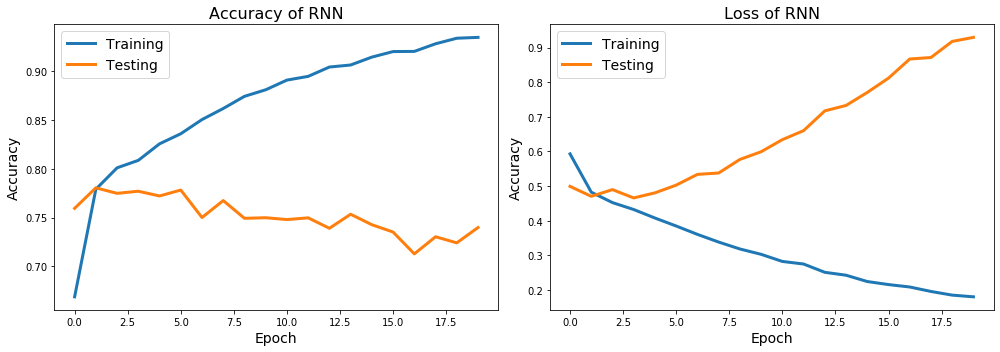

In [0]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, history.history['accuracy'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_accuracy'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Accuracy of RNN', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(history.epoch, history.history['loss'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_loss'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Loss of RNN', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

plt.tight_layout()

Même avec une validation croisée pour trouver les paramètres optimaux, les résultats ne sont pas meilleurs qu'avant et on retrouve le même cas que juste avant. Nous pouvons donc faire deux hypothèses: soit la complexité du problème fait que nous ne pouvons pas obtenir de meilleurs résultats avec ce genre de réseaux, soit les données en entrées pourraient être retravaillées pour obtenir de meilleurs résultats: faut-il conserver uniquement les 10000 mots les plus fréquents? Faut-il supprimer uniquement les 20 mots les plus courants?

**Question (bonus)**

You may try to implement a first LSTM on this example (see next practical session).

In [0]:
model_lstm = Sequential()

# Embedding layer, turns positive integers or indices into dense vectors of fixed size
model_lstm.add(Embedding(max_features, 32))
model_lstm.add(LSTM(10,input_shape=input_shape))  
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(1, activation='sigmoid', name='dense_sigmoid'))

model_lstm.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

model_lstm.summary()

Model: "sequential_114"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, None, 32)          32000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                1720      
_________________________________________________________________
dropout_197 (Dropout)        (None, 10)                0         
_________________________________________________________________
dense_sigmoid (Dense)        (None, 1)                 11        
Total params: 33,731
Trainable params: 33,731
Non-trainable params: 0
_________________________________________________________________


In [0]:
batch_size = 64
epochs = 20

history = model_lstm.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test))

C:\Users\axelc\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 16s 624us/step - loss: 0.5666 - accuracy: 0.7198 - val_loss: 0.4661 - val_accuracy: 0.7836
Epoch 2/20
25000/25000 [==============================] - 15s 612us/step - loss: 0.4654 - accuracy: 0.7925 - val_loss: 0.4345 - val_accuracy: 0.7932
Epoch 3/20
25000/25000 [==============================] - 15s 607us/step - loss: 0.4413 - accuracy: 0.8035 - val_loss: 0.4373 - val_accuracy: 0.7929
Epoch 4/20
25000/25000 [==============================] - 15s 612us/step - loss: 0.4282 - accuracy: 0.8094 - val_loss: 0.4318 - val_accuracy: 0.7948
Epoch 5/20
25000/25000 [==============================] - 15s 608us/step - loss: 0.4166 - accuracy: 0.8142 - val_loss: 0.4407 - val_accuracy: 0.7912
Epoch 6/20
25000/25000 [==============================] - 15s 604us/step - loss: 0.4105 - accuracy: 0.8156 - val_loss: 0.4358 - val_accuracy: 0.7927
Epoch 7/20
25000/25000 [==============================] 

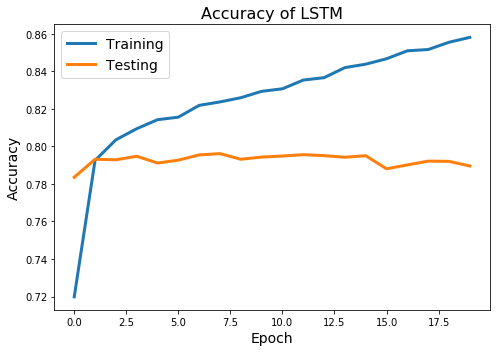

In [0]:
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['accuracy'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_accuracy'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Accuracy of LSTM', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.tight_layout()

Ici aussi, les résultats ne sont pas meilleurs que précedemment mais on peut observer que l'ajout d'une couche LSTM fait moins décroître le taux de réussite sur l'échantillon de test et ses variations sont moins "brutales". C'est donc quand même mieux qu'avant. Le taux de réussite sur l'échantillon de test stagne aux alentours de 79%.